# **EDA**

## PRESENTACIÓN DEL DATAFRAME

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from IPython.display import display
from statsmodels.multivariate.manova import MANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import f_oneway
import itertools

In [2]:
df_drugs = pd.read_csv("../data/data_clean/drugs.csv", index_col=0)
df_drugs_no_na = pd.read_csv("../data/data_clean/drugs_no_na.csv", index_col=0)

In [3]:
df_drugs

,country,survey_year,prevalence_(%),substance,recall_period,age,sample_size,males_(%),females_(%),gender_gap
0,Austria,2020,22.7,Cannabis,Lifetime,Adults (15-64),4650.0,24.8,20.6,4.2
1,Austria,2020,27.2,Cannabis,Lifetime,Young adults (15-34),1712.0,26.8,27.6,-0.8
2,Austria,2020,6.3,Cannabis,Last year,Adults (15-64),4650.0,6.8,5.8,1.0
3,Austria,2020,11.1,Cannabis,Last year,Young adults (15-34),1712.0,10.7,11.4,-0.7
4,Austria,2020,3.6,Cannabis,Last month,Adults (15-64),4650.0,4.0,3.1,0.9
...,...,...,...,...,...,...,...,...,...,...
1038,Türkiye,2017,47.0,Tobacco,Lifetime,Young adults (15-34),NaN,61.9,33.2,28.7
1039,Türkiye,2017,33.4,Tobacco,Last year,Adults (15-64),NaN,45.0,22.5,22.5
1040,Türkiye,2017,33.2,Tobacco,Last year,Young adults (15-34),NaN,45.4,20.6,24.8
1041,Türkiye,2017,31.5,Tobacco,Last month,Adults (15-64),NaN,42.8,21.0,21.8


El conjunto de datos contiene 1043 observaciones de consumo de estupefacientes en Europa y Turquía, recopiladas en diversos años y para distintos grupos de edad. Cada fila representa una medición específica del consumo de una sustancia en un país, un período de referencia y un grupo etario determinado.

**Columnas principales:**

* country: País donde se realizó la encuesta (países europeos y Turquía)

* survey_year: Año en el cual se realizó la encuesta (rango 2008-2022).

* prevalence_(%): Porcentaje de la población que ha consumido el estupefaciente 

* substance: Tipo de sustancia evaluada, como Cannabis, Tobacco, Cocaine, entre otros.

* recall_period: Periodo de referencia del consumo: Lifetime (consumo alguna vez), Last year (último año), Last month (último mes).

* age: Grupo de edad de la población encuestada - Adults (15-64) o Young adults (15-34).

* sample_size: Tamaño de la muestra utilizada en la encuesta

* males_(%) y females_(%): Porcentaje de hombres y mujeres que reportan haber consumido la sustancia.

* gender_gap: Diferencia entre hombres y mujeres (males_(%) - females_(%))


# **ANÁLISIS: CARDINALIDAD**

## 1. CARDINALIDAD: ANÁLISIS UNIVARIANTE

In [ ]:
# Función que calcula la cardinalidad y el tipo de variable
def cardinalidad(df_in, umbral_categoria = 10, umbral_continua = 30):

    resultado = []
    for col in df_in.columns:
        card = df_in[col].nunique()
        porc_card = df_in[col].nunique()/len(df_in) * 100
        tipo = df_in[col].dtypes
        if card == 2:
            clasif = "Binaria"
        elif card < umbral_categoria:
            clasif = "Categórica"
        elif card >= umbral_categoria:
            if porc_card >= umbral_continua:
                clasif = "Numérica Continua"
            else:
                clasif = "Numérica Discreta"

        # Añadimos los resultados a la lista
        resultado.append({
            "columna": col,
            "tipo": tipo,
            "cardinalidad": card,
            "porcentaje_card": porc_card,
            "clasificacion": clasif
        })
    
    # Convertimos la lista de dicts en dataframe
    df_resul = pd.DataFrame(resultado)
        
    return df_resul

# 3. Función que representa las frecuencias absolutas o relativas en gráficos
def pinta_distribucion_categoricas(df, columnas_categoricas, relativa=False, mostrar_valores=False):
    num_columnas = len(columnas_categoricas)
    num_filas = (num_columnas // 2) + (num_columnas % 2)

    fig, axes = plt.subplots(num_filas, 2, figsize=(15, 5 * num_filas))
    axes = axes.flatten() 

    for i, col in enumerate(columnas_categoricas):
        ax = axes[i]
        if relativa:
            total = df[col].value_counts().sum()
            serie = df[col].value_counts().apply(lambda x: x / total)
            sns.barplot(x=serie.index, y=serie, ax=ax, palette='viridis', hue = serie.index, legend = False)
            ax.set_ylabel('Frecuencia Relativa')
        else:
            serie = df[col].value_counts()
            sns.barplot(x=serie.index, y=serie, ax=ax, palette='viridis', hue = serie.index, legend = False)
            ax.set_ylabel('Frecuencia')

        ax.set_title(f'Distribución de {col}')
        ax.set_xlabel('')
        ax.tick_params(axis='x', rotation=45)

        if mostrar_valores:
            for p in ax.patches:
                height = p.get_height()
                ax.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height), 
                            ha='center', va='center', xytext=(0, 9), textcoords='offset points')

    for j in range(i + 1, num_filas * 2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def columnas_numericas(df):
    num_col = df.describe().columns.to_list()
    return num_col

# Función para representar boxplots de columnas numéricas
def plot_multiple_boxplots(df, columns, dim_matriz_visual = 2):
    num_cols = len(columns)
    num_rows = num_cols // dim_matriz_visual + num_cols % dim_matriz_visual
    fig, axes = plt.subplots(num_rows, dim_matriz_visual, figsize=(12, 6 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        if df[column].dtype in ['int64', 'float64']:
            sns.boxplot(data=df, x=column, ax=axes[i])
            axes[i].set_title(column)

    # Ocultar ejes vacíos
    for j in range(i+1, num_rows * 2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def plot_histo_dens(df, columns, bins=None):
    num_cols = len(columns)
    num_rows = num_cols // 2 + num_cols % 2
    fig, axes = plt.subplots(num_rows, 2, figsize=(12, 6 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        if df[column].dtype in ['int64', 'float64']:
            if bins:
                sns.histplot(df[column], kde=True, ax=axes[i], bins=bins)
            else:
                sns.histplot(df[column], kde=True, ax=axes[i])
            axes[i].set_title(f'Histograma y KDE de {column}')

    # Ocultar ejes vacíos
    for j in range(i + 1, num_rows * 2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Función que representa el histograma y el boxplot de varias variables
def plot_combined_graphs(df, columns, whisker_width=1.5):
    num_cols = len(columns)
    if num_cols:
        
        fig, axes = plt.subplots(num_cols, 2, figsize=(12, 5 * num_cols))
        print(axes.shape)

        for i, column in enumerate(columns):
            if df[column].dtype in ['int64', 'float64']:
                # Histograma y KDE
                sns.histplot(df[column], kde=True, ax=axes[i,0] if num_cols > 1 else axes[0])
                if num_cols > 1:
                    axes[i,0].set_title(f'Histograma y KDE de {column}')
                else:
                    axes[0].set_title(f'Histograma y KDE de {column}')

                # Boxplot
                sns.boxplot(x=df[column], ax=axes[i,1] if num_cols > 1 else axes[1], whis=whisker_width)
                if num_cols > 1:
                    axes[i,1].set_title(f'Boxplot de {column}')
                else:
                    axes[1].set_title(f'Boxplot de {column}')

        plt.tight_layout()
        plt.show()

## 2. CARDINALIDAD: ANÁISIS BIVARIANTE

In [ ]:
# Función análisis bivariante categóricas
def plot_categorical_relationship_fin(df, cat_col1, cat_col2, relative_freq=False, show_values=False, size_group = 5):

    # Prepara los datos
    count_data = df.groupby([cat_col1, cat_col2]).size().reset_index(name='count')
    total_counts = df[cat_col1].value_counts()
    
    # Convierte a frecuencias relativas si se solicita
    if relative_freq:
        count_data['count'] = count_data.apply(lambda x: x['count'] / total_counts[x[cat_col1]], axis=1)

    # Si hay más de size_group categorías en cat_col1, las divide en grupos de size_group
    unique_categories = df[cat_col1].unique()
    if len(unique_categories) > size_group:
        num_plots = int(np.ceil(len(unique_categories) / size_group))

        for i in range(num_plots):
            # Selecciona un subconjunto de categorías para cada gráfico
            categories_subset = unique_categories[i * size_group:(i + 1) * size_group]
            data_subset = count_data[count_data[cat_col1].isin(categories_subset)]

            # Crea el gráfico
            plt.figure(figsize=(5, 3))
            ax = sns.barplot(x=cat_col1, y='count', hue=cat_col2, data=data_subset, order=categories_subset)

            # Añade títulos y etiquetas
            plt.title(f'Relación entre {cat_col1} y {cat_col2} - Grupo {i + 1}')
            plt.xlabel(cat_col1)
            plt.ylabel('Frecuencia' if relative_freq else 'Conteo')
            plt.xticks(rotation=45)

            # Mostrar valores en el gráfico
            if show_values:
                for p in ax.patches:
                    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                                ha='center', va='center', fontsize=10, color='black', xytext=(0, size_group),
                                textcoords='offset points')

            # Muestra el gráfico
            plt.show()
    else:
        # Crea el gráfico para menos de size_group categorías
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x=cat_col1, y='count', hue=cat_col2, data=count_data)

        # Añade títulos y etiquetas
        plt.title(f'Relación entre {cat_col1} y {cat_col2}')
        plt.xlabel(cat_col1)
        plt.ylabel('Frecuencia' if relative_freq else 'Conteo')
        plt.xticks(rotation=45)

        # Mostrar valores en el gráfico
        if show_values:
            for p in ax.patches:
                ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center', fontsize=10, color='black', xytext=(0, size_group),
                            textcoords='offset points')

        # Muestra el gráfico
        plt.show()

def grafico_dispersion_con_correlacion(df, columna_x, columna_y, tamano_puntos=50, mostrar_correlacion=False):
    """
    Crea un diagrama de dispersión entre dos columnas y opcionalmente muestra la correlación.

    Args:
    df (pandas.DataFrame): DataFrame que contiene los datos.
    columna_x (str): Nombre de la columna para el eje X.
    columna_y (str): Nombre de la columna para el eje Y.
    tamano_puntos (int, opcional): Tamaño de los puntos en el gráfico. Por defecto es 50.
    mostrar_correlacion (bool, opcional): Si es True, muestra la correlación en el gráfico. Por defecto es False.
    """

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=columna_x, y=columna_y, s=tamano_puntos)

    if mostrar_correlacion:
        correlacion = df[[columna_x, columna_y]].corr().iloc[0, 1]
        plt.title(f'Diagrama de Dispersión con Correlación: {correlacion:.2f}')
    else:
        plt.title('Diagrama de Dispersión')

    plt.xlabel(columna_x)
    plt.ylabel(columna_y)
    plt.grid(True)
    plt.show()

# **ANÁLISIS BASE**

A continuación, se muestran una serie de análisis base para todas las hipótesis del presente estudio.

In [8]:
df_drugs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1043 entries, 0 to 1042
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         1043 non-null   object 
 1   survey_year     1043 non-null   int64  
 2   prevalence_(%)  1043 non-null   float64
 3   substance       1043 non-null   object 
 4   recall_period   1043 non-null   object 
 5   age             1043 non-null   object 
 6   sample_size     950 non-null    float64
 7   males_(%)       1017 non-null   float64
 8   females_(%)     1001 non-null   float64
 9   gender_gap      1001 non-null   float64
dtypes: float64(5), int64(1), object(4)
memory usage: 89.6+ KB


El presente análisis muestra que nuestro dataset contiene 1043 filas, hehcho que mostraría un tamaño moderado para análisis estadísticos.

Asimismo, hay 10 columnas, de las cuales 4 son **categóricas** (country, substance, recall_period, age) y 6 **numéricas** (survey_year, prevalence_(%), sample_size, males_(%), females_(%), gender_gap)

Además, se observan valores faltantes (NaN) en:

* sample_size (950 de 1043) → faltaría información en algunas encuestas sobre el número de personas encuestadas.

* males_(%) (1017 de 1043) y females_(%) (1001 de 1043) → algunas encuestas no informan el porcentaje por sexo.

* gender_gap (1001 de 1043) → ya que se calcula como diferencia de los anteriores, los valores faltantes se transmiten.


In [9]:
df_drugs.describe()

,survey_year,prevalence_(%),sample_size,males_(%),females_(%),gender_gap
count,1043.000000,1043.000000,950.000000,1017.000000,1001.000000,1001.000000
mean,2018.776606,17.558581,4260.586316,19.904621,15.596803,4.624276
std,2.174479,26.759251,4568.853108,28.697494,25.437743,6.281016
min,2008.000000,0.000000,442.000000,0.000000,0.000000,-4.000000
25%,2018.000000,0.600000,1572.000000,0.800000,0.300000,0.400000
50%,2019.000000,2.800000,2957.000000,3.900000,1.800000,1.900000
75%,2020.000000,26.150000,4994.000000,32.000000,21.300000,6.600000
max,2022.000000,98.900000,26344.000000,99.600000,98.200000,38.400000


El estudio de .describe() proporciona información descriptiva de diversas columnas:
**survey_year**

* Media: 2018.78, desviación estándar: 2.17.

Los datos son recientes, principalmente del periodo 2018–2022, con algunos registros desde 2008.

Esto indica que el análisis se centra en consumos actuales o recientes, lo que es coherente con un EDA de tendencias modernas.

**prevalence_(%)**

* Media: 17.56%, desviación estándar: 26.76%, mínimo 0%, máximo 98.9%.

Hay una variabilidad alta en la prevalencia de consumo. La mayoría de los valores son bajos, pero hay encuestas con prevalencia muy alta, posiblemente para sustancias como alcohol o cannabis en grupos específicos.

**sample_size**

* Media: 4260, rango: 442–26,344.

La amplitud muestra que algunas encuestas son muy grandes y otras más pequeñas.

**males_(%) y females_(%)**

* Hombres: media 19.90%, std 28.69%

* Mujeres: media 15.60%, std 25.43%

En promedio, los hombres consumen más que las mujeres aunque hay una desviación estándard elevada. Esto podría mostrar dispersión e indicar que en algunos países tendrían consumos similares. 

**gender_gap**

* Media: 4.62%, mínimo -4%, máximo 38.4%

En promedio, hay mayor consumo en hombres, pero hay casos donde las mujeres superan a los hombres (valores negativos)

In [103]:
df_drugs.columns.tolist()

['country',
 'survey_year',
 'prevalence_(%)',
 'substance',
 'recall_period',
 'age',
 'sample_size',
 'males_(%)',
 'females_(%)',
 'gender_gap']

La lista de nuestras columnas confirma que tenemos todas las variables necesarias para analizar las hipótesis. Asimismo, es útil para planificar análisis univariantes (por ejemplo, solo prevalence_(%)), bivariantes (prevalence_(%) vs age o gender_gap) y multivariantes (prevalence_(%) vs gender_gap y country).

# **HIPÓTESIS 1**

>*H1. Los hombres consumen más estupefacientes que las mujeres en todos los grupos de edad*

## 1.1 ANÁLISIS UNIVARIANTE

Antes de nada, volvemos a mostrar el dataframe:

In [29]:
df_drugs

,country,survey_year,prevalence_(%),substance,recall_period,age,sample_size,males_(%),females_(%),gender_gap
0,Austria,2020,22.7,Cannabis,Lifetime,Adults (15-64),4650.0,24.8,20.6,4.2
1,Austria,2020,27.2,Cannabis,Lifetime,Young adults (15-34),1712.0,26.8,27.6,-0.8
2,Austria,2020,6.3,Cannabis,Last year,Adults (15-64),4650.0,6.8,5.8,1.0
3,Austria,2020,11.1,Cannabis,Last year,Young adults (15-34),1712.0,10.7,11.4,-0.7
4,Austria,2020,3.6,Cannabis,Last month,Adults (15-64),4650.0,4.0,3.1,0.9
...,...,...,...,...,...,...,...,...,...,...
1038,Türkiye,2017,47.0,Tobacco,Lifetime,Young adults (15-34),NaN,61.9,33.2,28.7
1039,Türkiye,2017,33.4,Tobacco,Last year,Adults (15-64),NaN,45.0,22.5,22.5
1040,Türkiye,2017,33.2,Tobacco,Last year,Young adults (15-34),NaN,45.4,20.6,24.8
1041,Türkiye,2017,31.5,Tobacco,Last month,Adults (15-64),NaN,42.8,21.0,21.8


Para explorar la primera hipótesis, que plantea que los hombres consumen más drogas que las mujeres, se muestran datos descriptivos de las principales variables de la hipótesis: age, males_(%), females_(%), substance y prevalence_(%).

In [10]:
df_drugs["age"].describe()

count               1043
unique                 2
top       Adults (15-64)
freq                 528
Name: age, dtype: object

In [11]:
df_drugs["males_(%)"].describe()

count    1017.000000
mean       19.904621
std        28.697494
min         0.000000
25%         0.800000
50%         3.900000
75%        32.000000
max        99.600000
Name: males_(%), dtype: float64

In [12]:
df_drugs["females_(%)"].describe()

count    1001.000000
mean       15.596803
std        25.437743
min         0.000000
25%         0.300000
50%         1.800000
75%        21.300000
max        98.200000
Name: females_(%), dtype: float64

In [13]:
df_drugs["prevalence_(%)"].describe()

count    1043.000000
mean       17.558581
std        26.759251
min         0.000000
25%         0.600000
50%         2.800000
75%        26.150000
max        98.900000
Name: prevalence_(%), dtype: float64

In [14]:
df_drugs["substance"].describe()

count         1043
unique           7
top       Cannabis
freq           171
Name: substance, dtype: object

La variable **age** dejaría ver que la muestra se divide en dos grupos: Adults (15-64) y Young adults (15-34). La categoría más frecuente es la de adultos (528 observaciones), hecho que indicaría que la mayor parte de los datos corresponde a población adulta a pesar de que también se dispone de una representación significativa de jóvenes. 

En cuanto a los porcentajes de consumo por **sexo**, los hombres presentan un promedio de consumo de 19.90% y una mediana de 3.90%, frente un promedio de 15.60% y mediana de 1.80% de las mujeres. Asimismo, se presenta una desviación estándard elevada (28.7% vs. 25.4% respectivamente) que muestra una gran variabilidad. La mediana baja sugeriría que, en la mayoría de los casos, el consumo es relativamente reducido, pero algunos casos puntuales elevan considerablemente la media, indicando que existen grupos con prevalencias muy altas.

Finalmente, la variable **prevalence_(%)** muestra un comportamiento similar: promedio de 17.56% y rango que va de 0% a 98.9%. Esto confirmaría la heterogeneidad del consumo. 

Respecto a las **sustancias**, la mayoría de los registros corresponden a Cannabis (171 observaciones), aunque el dataset incluye un total de 7 tipos de drogas, como alcohol o cocaina, lo que permite comparar patrones de consumo entre distintas sustancias.

En conjunto, este análisis univariante sugiere que, en promedio, los hombres presentan mayores niveles de consumo que las mujeres, aunque existen casos donde la diferencia es mínima o incluso se invierte, y que la distribución de consumo varía considerablemente según grupo etario y sustancia.

### 1.1.1 Análisis univariante de variables **categóricas**

Para realizar el análisis univariante, se ha examinado la distribución de las **variables categóricas** relevantes para la primera hipótesis: substance y age.

Se ha hecho también un **conteo de los valores absolutos**:

In [42]:
categorical_var = [  
    "substance",
    "age",
]

In [57]:
for catego in categorical_var:
	print(f"Para {catego}")
	print(df_drugs[catego].value_counts())
	print("\n"*2)

Para substance
substance
Cannabis        171
Cocaine         159
Ecstasy         159
Amphetamines    149
LSD             148
Alcohol         132
Tobacco         125
Name: count, dtype: int64



Para age
age
Adults (15-64)          528
Young adults (15-34)    515
Name: count, dtype: int64





**Sustancia (substance)**
El dataset incluye 7 tipos de sustancias: Cannabis, Cocaína, Éxtasis, Anfetaminas, LSD, Alcohol y Tabaco. La distribución absoluta de sus registros muestra que Cannabis es la sustancia más frecuente (171 observaciones), seguida de Cocaína y Éxtasis (159 observaciones cada una). Las otras sustancias se reparten de manera relativamente uniforme, con un mínimo de 125 registros para Tabaco.

**Grupos de edad (age)**
El conteo absoluto indica que la muestra está muy equilibrada entre los Adultos (15-64 años) con 528 observaciones y los Jóvenes adultos (15-34 años) con 515 observaciones. Esto permite analizar cómo varía el consumo entre los hombres y las mujeres en función de la edad, por ejemplo, sin que uno de los grupos predomine sobre el otro.


Asimismo, se han generado un gráfico de barras para estas variables categóricas:

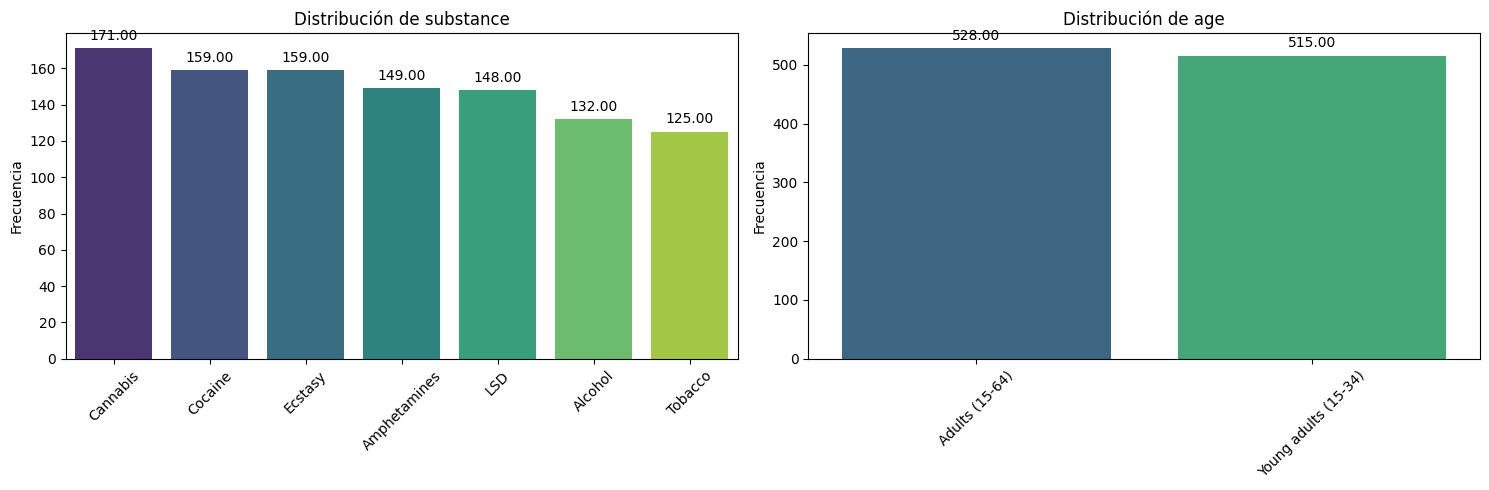

In [135]:
pinta_distribucion_categoricas(df_drugs, ["substance", "age"], relativa=False, mostrar_valores=True)

Este gráfico muestra la distribución de las sustancias, así como la prácticamente igualdad entre los grupos de edad. Con esta, se puede identificar dónde están concentrados la mayor parte de datos.
Ambas gráficas confirman lo que muestran los conteos absolutos anteriormanete mencionados:
* Substance: predomina el consumo de cannabis, seguida de cocaina, extasis, anfetaminas, LSD, alcohol y, finalmente, tabaco
* Age: se observa una representación equilibrada entre ambos grupos de edad

Para complementar el análisis en términos absolutos, se ha calculado la distribución **relativa** las variables substance y age, expresando los datos en porcentajes sobre el total de observaciones (1043).

In [105]:
for catego in categorical_var:
	print(f"Para {catego}")
	print(df_drugs[catego].value_counts()/len(df_drugs)*100)
	print("\n"*2)

Para substance
substance
Cannabis        16.395014
Cocaine         15.244487
Ecstasy         15.244487
Amphetamines    14.285714
LSD             14.189837
Alcohol         12.655801
Tobacco         11.984660
Name: count, dtype: float64



Para age
age
Adults (15-64)          50.623202
Young adults (15-34)    49.376798
Name: count, dtype: float64





**Substance**: Igual que en el análisis anterior, el cánnabis es la sustancia que más se observa (16.4%), seguida de la cocaina y extasis (15.24% cada una), las anfetaminas y el LSD (14.3% y 14.2% respectivamente), el alcohol (12.66%) y, finalmente, el tabado (12%)

**Age**: Se vuelve a apreciar que las dos franjas de edad (adulto y adultos jóvenes) están equilibrados, con aproximadamente los dos un 50% de representación

Para volver a observarlo de forma visual, se presenta, a continuación, una gráfica con los datos relativos aquí presentados:

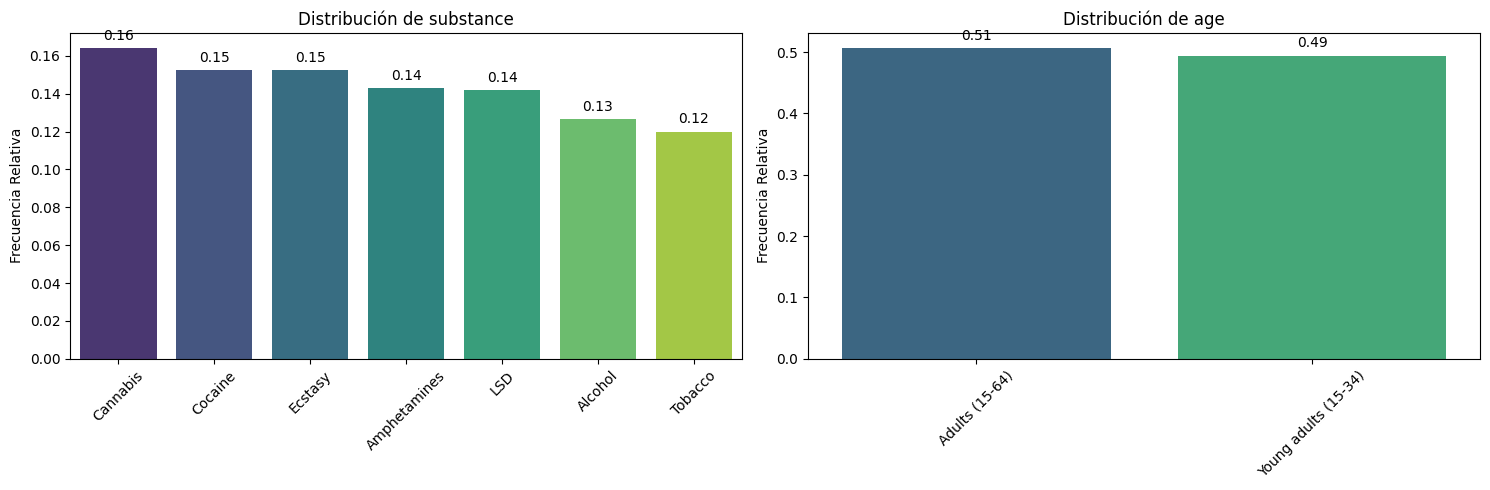

In [134]:
pinta_distribucion_categoricas(df_drugs, ["substance", "age"], relativa=True, mostrar_valores=True)

Tanto el análisis absoluto como el relativo indican que nuestro dataset tiene correcta diversidad de sustancias y equilibrio de edad, hecho que proporciona una base sólida para analizar la Hipótesis 1 respecto las diferencias de consumo entre hombres y mujeres.

### 1.1.2 Análisis univariante de variables **Numéricas**

Se ha llevado a cabo un análisis de las variables numéricas relevantes para la primera hipótesis, la cual tiene como objetivo estudiar si los hombres consumen más estupefacientes que las mujeres en todos los rangos de edad. Para ello, las **variables numéricas** que han sido examinadas son: prevalence_(%), males_(%) y females_(%).

In [30]:
num_cols = columnas_numericas(df_drugs)
numeric_cols = [
    "prevalence_(%)",
    "males_(%)",
    "females_(%)",
]   

Para el análisis univariante de las variables numéricas, tal y como se ha mencionado anteriormente, se seleccionaron únicamente prevalence_(%), males_(%) y females_(%) puesto que son las columnas vinculadas de forma directa con la Hipótesis 1. A pesar de que nuestro dataset dispone de otras columnas que también son numéricas, nuestra selección nos permite centrarnos en las métricas que son relevantes para nuestro estudio.

Asimismo y, de manera complementaria, se han identificado las columnas numéricas de nuestro dataset con el objetivo de disponer de una visión general del comportamiento de las variables.

Por su parte, se han generado histogramas con curvas de densidad, así como boxplots para las variables **prevalence_(%), males_(%) y females_(%)** para analizar visualmente patrones de consumo y facilitar la interpretación de la Hipótesis 1.

*Histograma*

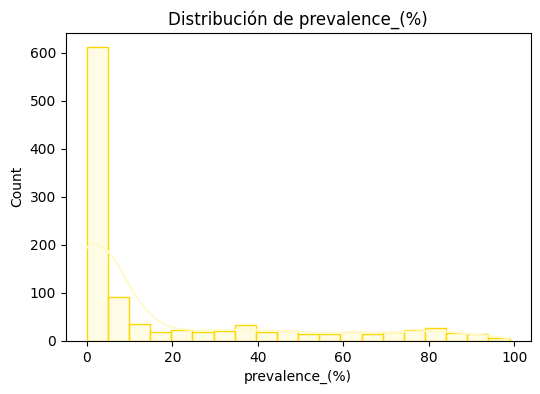

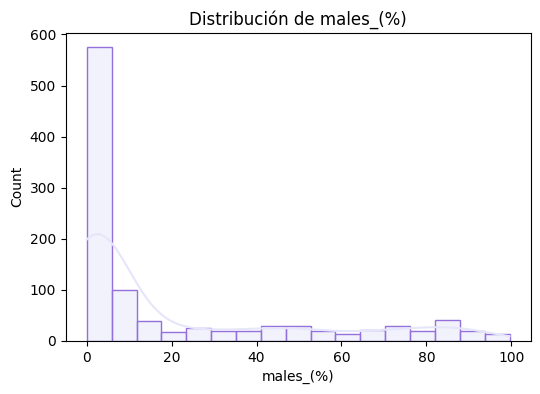

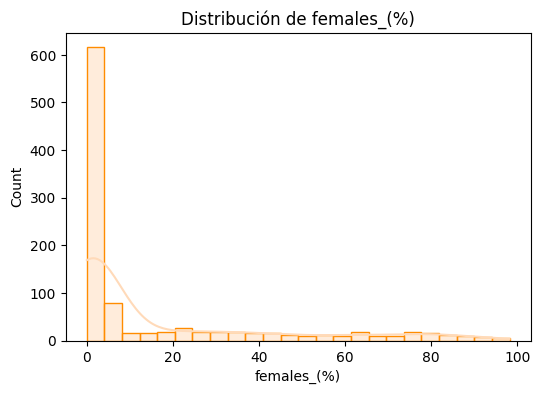

In [133]:
numeric_cols = ["prevalence_(%)", "males_(%)", "females_(%)"]
colors = ["#FFFACD", "#E6E6FA", "#FFDAB9"]
border_colors = ["#FFD700", "#9370DB", "#FF8C00"]

for i, col in enumerate(numeric_cols):
    plt.figure(figsize=(6,4))
    sns.histplot(
        df_drugs[col].dropna(),
        kde=True,
        color=colors[i],
        edgecolor=border_colors[i]
    )
    plt.title(f"Distribución de {col}")
    plt.show()

*Bloxplot*

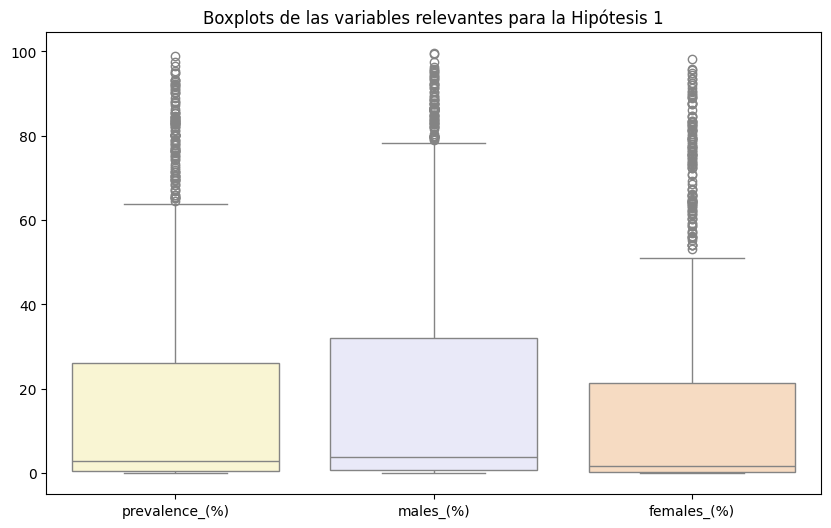

In [127]:
numeric_cols2 = ["prevalence_(%)", "males_(%)", "females_(%)"]
colors = ["#FFFACD", "#E6E6FA", "#FFDAB9"]

plt.figure(figsize=(10,6))
sns.boxplot(data=df_drugs[numeric_cols2], palette = colors)
plt.title("Boxplots de las variables relevantes para la Hipótesis 1")
plt.show()

**Prevalencia (prevalence_(%)**:

* El *histograma* expone que la mayoría de los registros se concentra en valores bajos (cercanos a 0–5%) a pesar de que hay casos extremos cercanos a 100%. Por su parte, la curva de densidad indicaría una distribución asimétrica con una larga cola hacia valores altos.

* Asimismo, los *boxplots* confirman la presencia de outliers (prevalencias muy elevadas en ciertas sustancias, grupos o países.

En conclusión, aunque la media (17.6%) es relativamente alta, la mediana (2.8%) mostraría que la mayoría de los registros reportan consumos bajos. Ello indicaría que existen determinados casos extremos que elevarían la media.

**Consumo masculino (males_(%))**:

* El *histograma* muestra una concentración de valores bajos, con ciertos casos de consumo muy alto. Su media (19.9%) es notablemente superior a la mediana (3.9%), hecho que indicaría que la mayoría de hombres tiene consumos bajos aunque existen valores extremos que elevarían el promedio 

El *boxplot* refleja claramente los outliers y la gran dispersión, confirmando diferencias significativas entre países, sustancias y grupos etarios.

**Consumo femenino (females_(%))**:

* La distribución es similar a la de los hombres: la mayoría de valores son bajos pero existen registros con consumos elevados. Por su parte, tanto la media (15.6%) como la mediana (1.8%) son menores que las de los hombres, sugiriendo que, en términos generales los hombres consumen más que las mujeres. No obstante, cabe tener en consideración que existen casos en los cuales la diferencia es pequeña o se invierte.

* Los *boxplots* muestran también outliers en este caso, indicando variabilidad significativa en ciertos contextos.

Finalmene y, para completar el análisis univariante, se ha calculado el **rango** de cada variable numérica, esto es, la diferencia entre el valor máximo y mínimo. Con ello podemos evaluar la amplitud de los datos, así como la posible presencia de valores extremos que influirían en estadísticos de tendencia central. 

In [122]:
df_drugs.describe().loc["max"] - df_drugs.describe().loc["min"]

survey_year          14.0
prevalence_(%)       98.9
sample_size       25902.0
males_(%)            99.6
females_(%)          98.2
gender_gap           42.4
dtype: float64

Los resultados del análisis del rango muestran la siguiente información:

* survey_year: tiene un rango de 14 años, reflejando que los datos abarcarían, princialmente, de 2008 a 2022.

* prevalence_(%): presenta un rango de 98.9%, mostrando que la prevalencia de consumo varíaría desde 0% hasta casi 100% en determinados registros.

* sample_size: dispone de un rango de 25,902 encuestados, indicando una variabilidad alta en el tamaño de las muestras.

* males_(%) y females_(%): tienen rangos de 99.6% y 98.2% respectivamente, hecho que confirma la existencia de valores extremos en el consumo reportado por sexo

* gender_gap: presenta un rango de 42.4%, mostrando diferencias significativas entre hombres y mujeres en algunos casos.

De forma complementaria, se ha realizado una representación gráfica mediante histogramas:

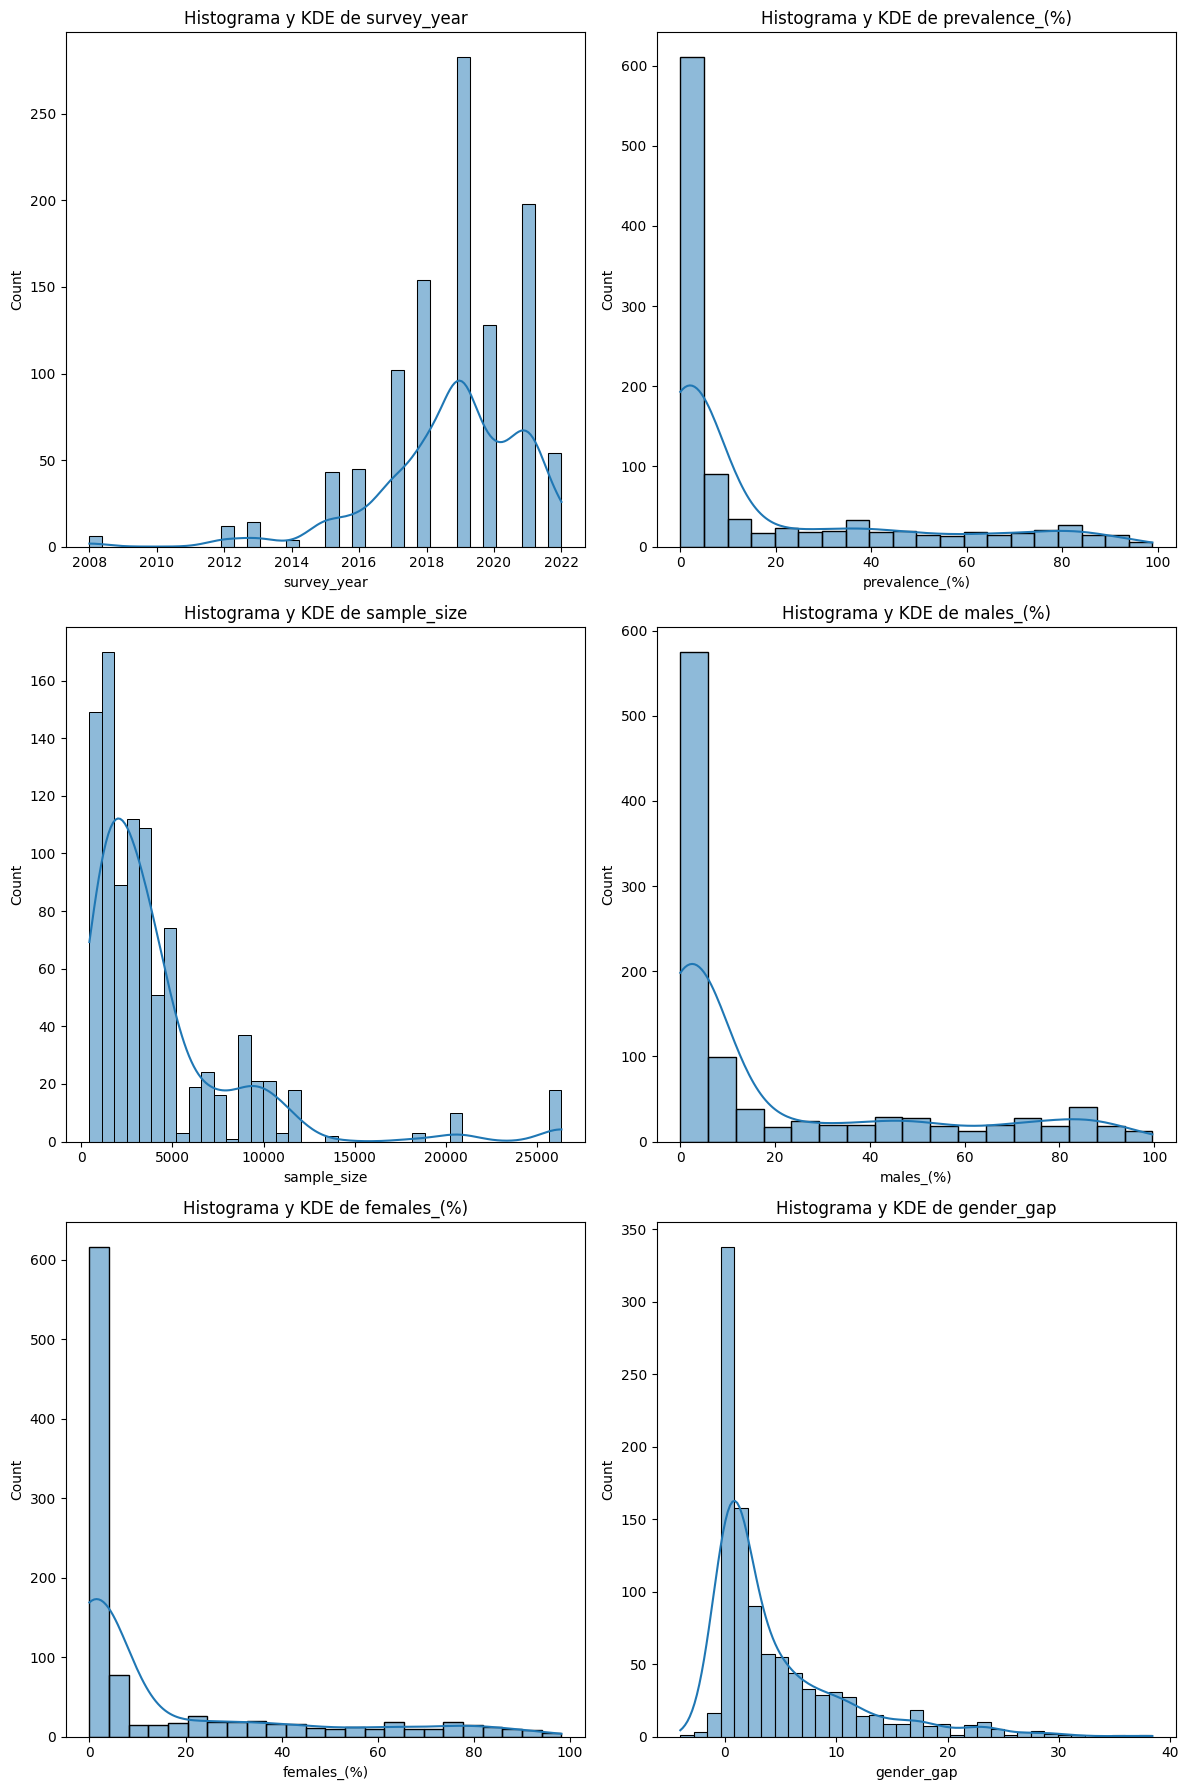

In [123]:
plot_histo_dens(df_drugs, columns=num_cols)

Estos histogramas muestran la distribución de cada una de las variables numéricas y nos permite identificar concentraciones de valores bajos, así como colas largas con registros extremos.

En las variables relevantes para la presente hipótesis, esto es, prevalence_(%), males_(%), females_(%), los valores se concentran, principalmente, en niveles bajos. No obstante, se aprecia la existencia de regsitros extremos que elevarían tanto la media como el rango.

Esta representación gráfica refuerza la interpretación de los boxplots y histogramas anteriores, mostrando de manera visual la heterogeneidad y dispersión de los datos.

En conclusión estos análisis confirman que las variables de consumo presentan gran variabilidad y outliers. 

Asimismo, los hombres tienen consumos más elevados en promedio que las mujeres, a pesar de que la dispersión es elevada, hecho que justificaría continuar con análisis bivariantes para explorar diferencias por sexo y grupos de edad.

## 1.2 ANÁLISIS BIVARIANTE

Para profundizar en la Hipótesis 1, se ha realizado un análisis bivariante, el cual nos ha permitido explorar relaciones entre 2 variables a la vez, así como apreciar cómo varía el consumo de estupefacientes en función del sexo, la edad y la sustancia. El análisis se ha organizado en tres secciones, según el tipo de variables involucradas:
* Categórica - categórica
* Numérica - numérica
* Categórica - numérica

### ANÁLISIS CATEGÓRICA - CATEGÓRICA

En este apartado se analiza la relación existente entre las variables categóricas: 

* age (grupo de edad)
* substance (tipo de sustancia)

El objetivo ha sido identificar posibles patrones en la distribución del consumo.
De esta forma, hemos podido evaluar si existen grupos de edad que estén más representados dentro del consumo de ciertas sustancias y hemos podido detectar si existen concentraciones de observaciones en ciertas combinaciones de categorías.

In [148]:
df_drugs.groupby("age", as_index = False)["substance"].value_counts(normalize = True)

,age,substance,proportion
0,Adults (15-64),Cannabis,0.164773
1,Adults (15-64),Cocaine,0.151515
2,Adults (15-64),Ecstasy,0.151515
3,Adults (15-64),Amphetamines,0.142045
4,Adults (15-64),LSD,0.140152
5,Adults (15-64),Alcohol,0.128788
6,Adults (15-64),Tobacco,0.121212
7,Young adults (15-34),Cannabis,0.163107
8,Young adults (15-34),Cocaine,0.153398
9,Young adults (15-34),Ecstasy,0.153398


Los resultados de este análisis muestran que la distribución de sustancias es prácticamente homogénea en los dos grupos de edad: tanto en adultos (15–64) como en jóvenes adultos (15–34), el **cannabis** es la sustancia más frecuente, seguido por la cocaína y el éxtasis, mientras que el alcohol y el tabaco presentan proporciones ligeramente inferiores. Puede apreciarse que las diferencias entre grupos de edad son mínimas y no se  evidencian patrones diferenciados relevantes.

Este comportamiento podría sugerir que el grupo de edad no condiciona significativamente el tipo de sustancia registrada en el dataset, al menos desde un punto de vista descriptivo. Esto es, no se observa que ciertas sustancias estén asociadas de forma clara a un grupo de edad específico, sino que el consumo aparece repartido de manera similar entre adultos y jóvenes adultos.

In [149]:
df_drugs.groupby("substance")["age"].describe()

,count,unique,top,freq
substance,,,,
Alcohol,132,2,Adults (15-64),68
Amphetamines,149,2,Adults (15-64),75
Cannabis,171,2,Adults (15-64),87
Cocaine,159,2,Adults (15-64),80
Ecstasy,159,2,Adults (15-64),80
LSD,148,2,Adults (15-64),74
Tobacco,125,2,Adults (15-64),64


Desde la perspectiva inversa, esto es, analizando la composición por edad dentro de cada sustancia, se aprecia que todas las sustancias incluyen ambos grupos de edad, con una presencia ligeramente mayor de adultos (15–64). No obstante, esta diferencia es reducida y consistente entre sustancias, hecho que indicaría que no existe una sobrerrepresentación destacable de ningún grupo de edad en ninguna sustancia concreta.

Para complementar el análisis, se ha realizado una gráfica para poder comprenderlo de forma visual:

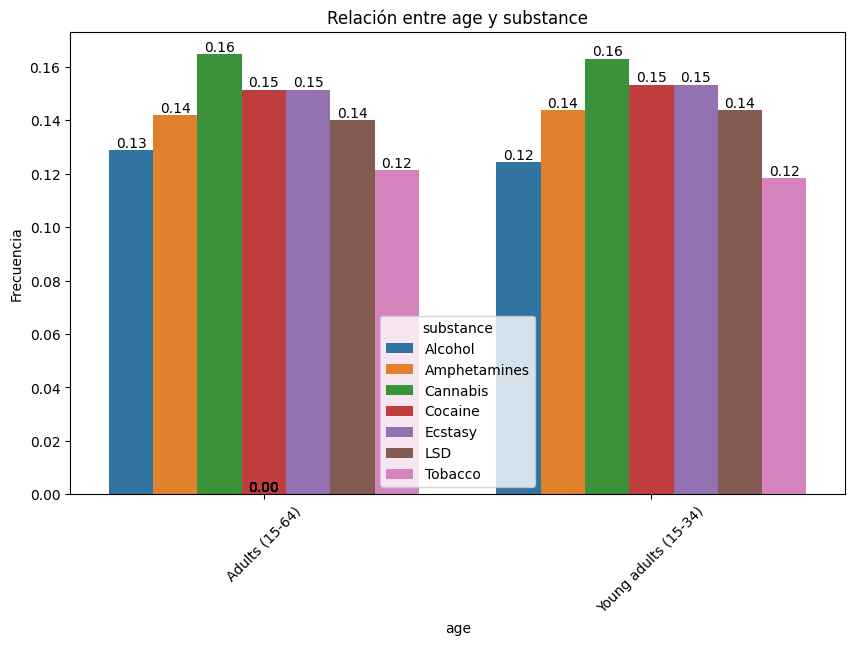

In [152]:
plot_categorical_relationship_fin(df_drugs, "age", "substance", relative_freq=True, show_values=True)

La visualización gráfica de las frecuencias relativas refuerza las conclusiones anteriores: barras de altura son similares para ambos grupos de edad en todas las sustancias. Así, no se han identificado concentraciones extremas que sugieran un vínculo destacable fuerte entre edad y tipo de sustancia.

En conclusión, el tipo de sustancia consumida no varía sustancialmente según el grupo de edad, mostrándose una estructura equilibrada entre edad y sustancia

Paralelamente y, con el objetivo de evaluar si existe una relación estadísticamente significativa entre el grupo de edad (age) y el tipo de sustancia (substance), se ha construido una **tabla de contingencia** y se ha aplicado el **test de Chi-cuadrado**.

In [150]:
tabla_contingencia = pd.crosstab(df_drugs['substance'], df_drugs['age'])
tabla_contingencia

age,Adults (15-64),Young adults (15-34)
substance,,
Alcohol,68,64
Amphetamines,75,74
Cannabis,87,84
Cocaine,80,79
Ecstasy,80,79
LSD,74,74
Tobacco,64,61


In [151]:
chi2, p, dof, expected = chi2_contingency(tabla_contingencia)


print("Valor Chi-Cuadrado:", chi2)
print("P-Value:", p)
print("Grados de Libertad:", dof)
print("Tabla de Frecuencias Esperadas:\n", expected)


Valor Chi-Cuadrado: 0.10311714713419907
P-Value: 0.9999780224419544
Grados de Libertad: 6
Tabla de Frecuencias Esperadas:
 [[66.82262704 65.17737296]
 [75.42857143 73.57142857]
 [86.56567593 84.43432407]
 [80.49089166 78.50910834]
 [80.49089166 78.50910834]
 [74.92233941 73.07766059]
 [63.27900288 61.72099712]]


La tabla de contingencia expone que, para todas las sustancias analizadas, las frecuencias observadas en adultos (15–64) y jóvenes adultos (15–34) son similares. Esta homogeneidad ya se intuía en el análisis descriptivo previos, pero el test estadístico permite confirmarlo.

Por su parte, el resultado del test Chi-cuadrado muestra:

* Un valor del estadístico χ² = 0.103 (extremadamente bajo).
* Un p-valor = 0.9999, superior al nivel de significación habitual, esto es, α = 0.05.
* 6 grados de libertad.

La comparación entre las frecuencias observadas y esperadas bajo el supuesto de independencia reforzaría que los valores esperados son prácticamente idénticos a los observados, explicando, así, el valor tan reducido del Chi-cuadrado.


Por lo tanto y, dado este **p-valor** tan elevado, no se puede rechazar la hipótesis nula de independencia, motivo por el cual puede señalarse que no existe  evidencia estadística de relación entre el grupo de edad y el tipo de sustancia:


### ANÁLISIS NUMÉRICA - NUMÉRICA

En segundo lugar, se han estudiado las relaciones entre variables numéricas destacables para la hipótesis 1: prevalence_(%), males_(%) y females_(%). Además, se han generado gráficos que complementan el análisis al permitir visualizar cómo se distribuyen las variables.

*Prevalencia*

(2,)


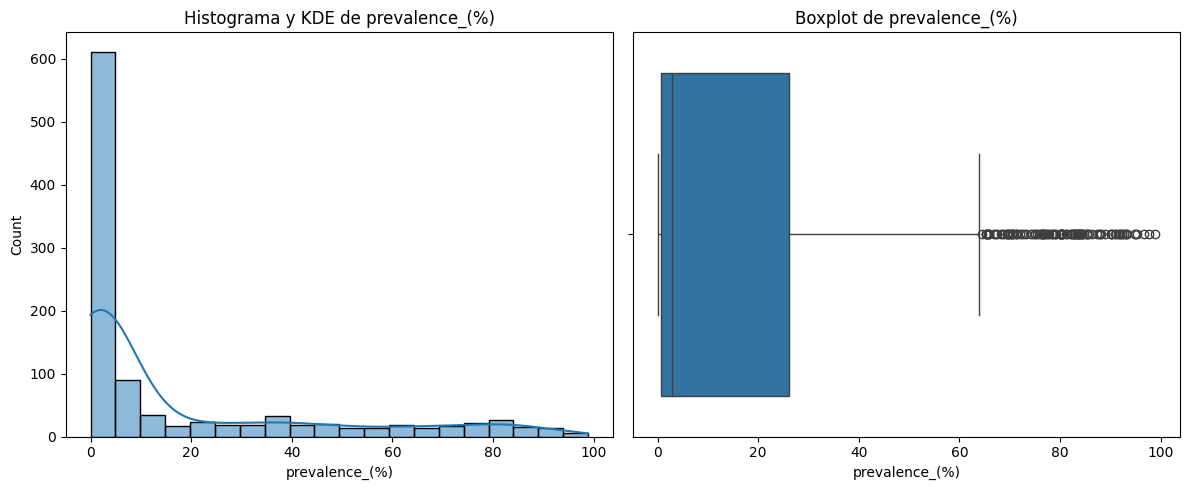

In [139]:
plot_combined_graphs(df_drugs,["prevalence_(%)"])

La mayoría de los registros presenta valores bajos de prevalencia: mediana de 2.8% y media de 17.6%. Esto indicaría la existencia de valores extremos que elevarían el promedio. Estos gráficos, por ende, refuerzan la idea de que hay una concentración de datos en valores bajos, así como de la presencia de outliers extremos. Esto, a su vez, muestra una variabilidad elevada en el consumo en función de la edad y la sustancia.

*Consumo de hombres*

(2,)


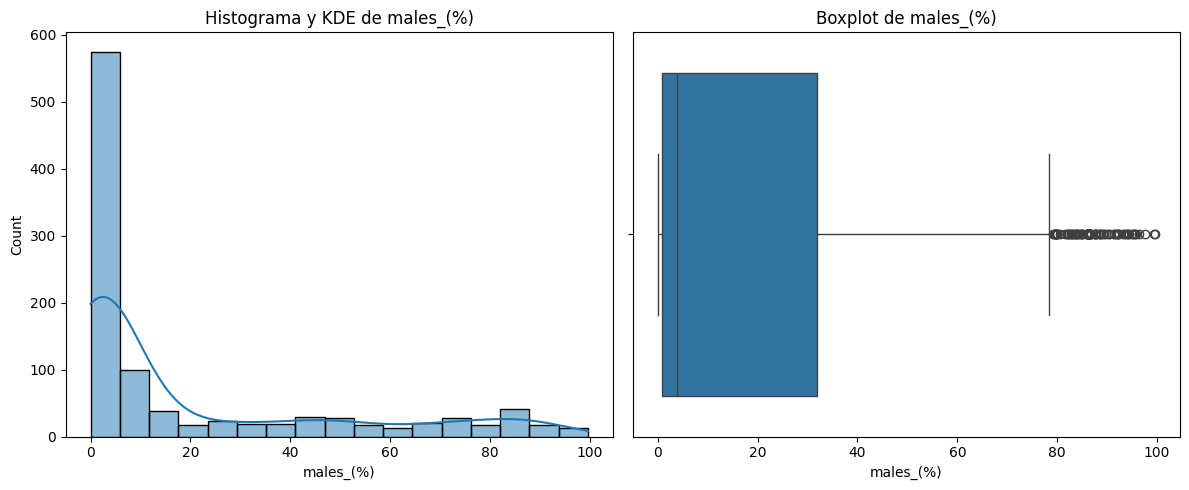

In [140]:
plot_combined_graphs(df_drugs, ["males_(%)"])

Igual que sucedía anteriormente, hay muchos valores bajos, mediana de 3.9% y media de 19.9%. La dispersión y los outliers reflejarían la existencia de casos extremos, los cuales aumentan la variabilidad general del dataset.

*Consumo de mujeres*

(2,)


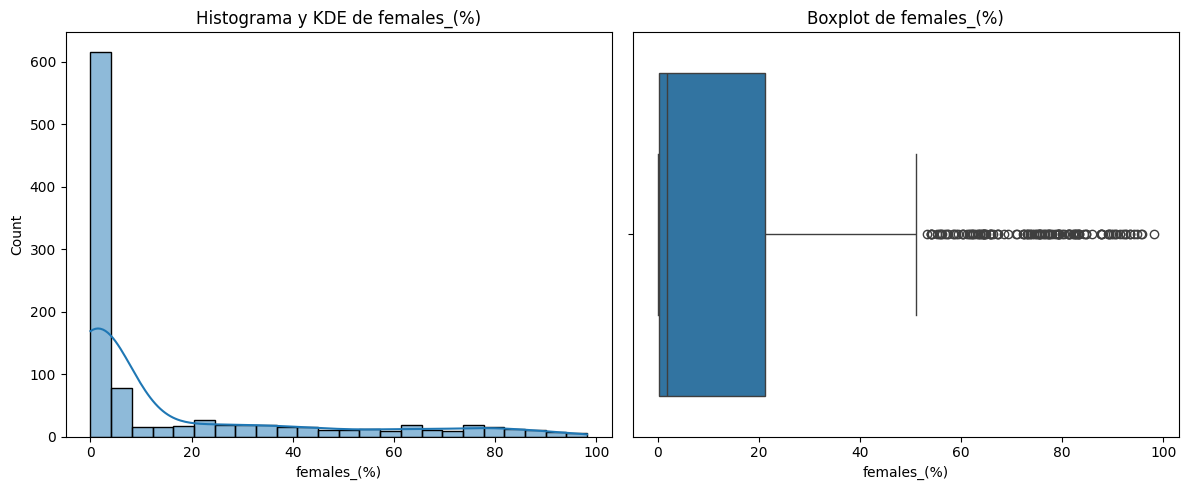

In [141]:
plot_combined_graphs(df_drugs, ["females_(%)"])

Los valores también están concentrados en rangos bajos (mediana de 1.8% y media de 15.6%).
La comparación con la variable de prevalencia total y el consumo masculino muestra que, en general, los hombres consumen más que las mujeres, aunque algunos casos presentan diferencias menores o incluso inversiones.

En términos generales, estos gráficos han mostrado una clara asimetría, dispersión y presencia de outliers en todas las variables de consumo.

Asimismo, se aprecia una relación evidente entre el consumo masculino, femenino y prevalencia total: confirmando que los registros con mayor consumo en hombres suelen tender a elevar la prevalencia general.


**Correlación**

Por otro lado, se han analizado las relaciones entre la prevalencia y el consumo por sexo a través de **coeficientes de correlación de Pearson** y **gráficos de dispersión con líneas de tendencia**.

*Prevalencia y consumo femenino:*

In [138]:
df_drugs[["prevalence_(%)","females_(%)"]].corr()

,prevalence_(%),females_(%)
prevalence_(%),1.000000,0.994642
females_(%),0.994642,1.000000


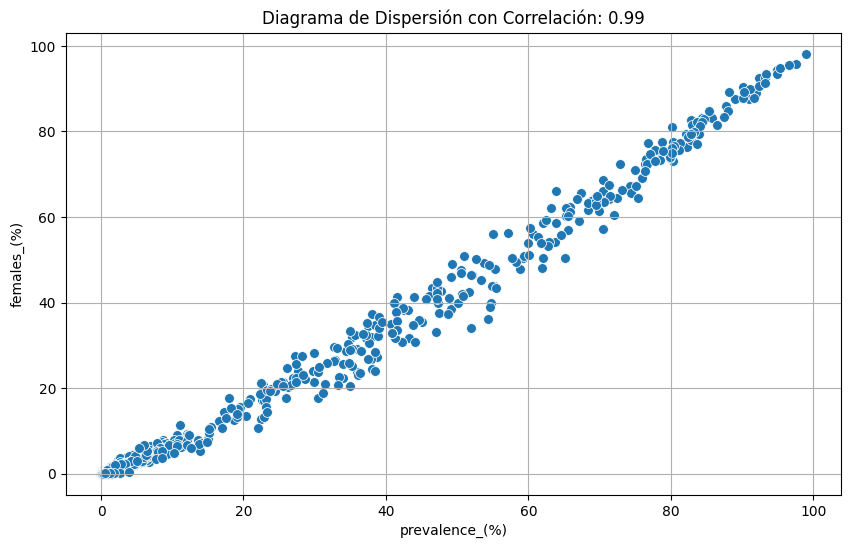

In [142]:
grafico_dispersion_con_correlacion(df_drugs, "prevalence_(%)", "females_(%)", mostrar_correlacion=True)

Se ha obtenido una correlación muy elevada (r = 0.995), que muestra una una relación lineal casi perfecta (apreciable también en el gráfico). Esto conlleva que los valores de prevalencia total aumentarían de forma directa a medida que incrementa el consumo femenino.

Por su parte, la gráfica muestra que los puntos se agrupan muy cerca de la línea de tendencia, indicando consistencia entre los datos de mujeres y la prevalencia general.

*Prevalencia y consuo masculino:*

In [137]:
df_drugs[["prevalence_(%)","males_(%)"]].corr()

,prevalence_(%),males_(%)
prevalence_(%),1.000000,0.995688
males_(%),0.995688,1.000000


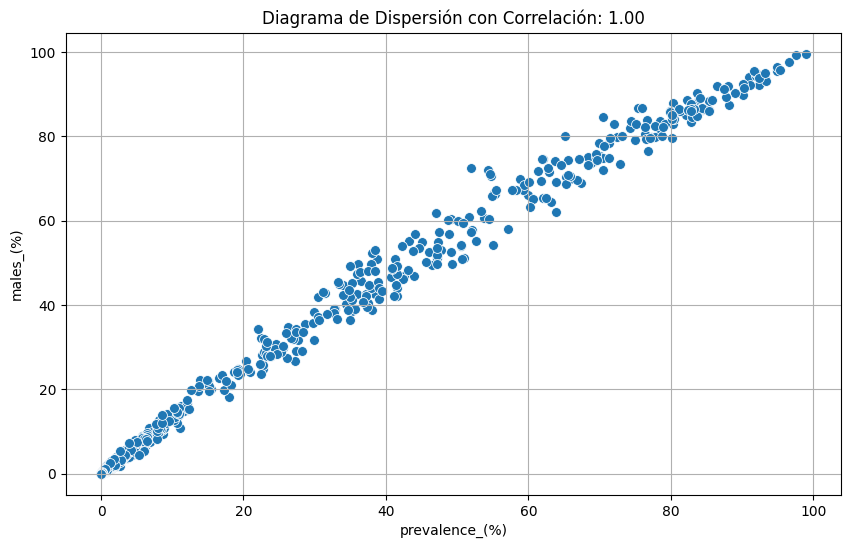

In [143]:
grafico_dispersion_con_correlacion(df_drugs, "prevalence_(%)", "males_(%)", mostrar_correlacion=True)

Igual que anteriormente, se tiene una correlación muy elevada (r = 0.996), hecho que muestra que el consumo masculino es un factor determinante en la prevalencia total.
A su vez, el gráfico mostraría también una alineación casi perfecta de los datos a lo largo de la línea.

Los outliers masculinos, por su parte, son más frecuentes que los femeninos y también elevan la prevalencia en ciertos registros: algunos grupos de edad o algunas sustancias tendrían consumos especialmente elevado en hombres. 

*Comparación:*

Tanto hombres como mujeres presentan correlaciones fuertes con la prevalencia del consumo. No obstante, la media del consumo de hombres es suprior a la de las mujeres (19.9% vs 15.6%), hecho que mostraría que el consumo masculino contribuiría a un aumento de la prevlencia general. 

Por su parte, los gráficos de dispersión nos han permitido apreciar dicha diferencia: los puntos de los hombres suelen ocupar valores más altos en el eje, sober todo en los registros extremos.


**Conclusión**

La prevalencia total está fuertemente correlacionada con ambos sexos, lo que confirma que la variación en consumo masculino y femenino explica casi por completo la variabilidad de la prevalencia reportada.

Estos análisis, además de cuantificar la relación, han permitido también visualizar los outliers y la dispersión, enriqueciendo, de esta forma, la interpretación.

Estos resultados reforzarían la Hipótesis 1, mostrando que los hombres tienden a consumir más que las mujeres, aunque ambos sexos tienen un impacto significativo en la prevalencia general.

### ANÁLISIS CATEGÓRICA - NUMÉRICA

En el presente apartado se analiza cómo las variables categóricas **edad** y **tipo de sustancia** se relacionan con las variables numéricas **prevalencia del consumo** y **consumo por sexo (males_(%), females_(%)**).

Se han aplicado **ANOVA** y se han generado **gráficos de barras y boxplots** para identificar diferencias significativas entre los grupos, así como visualizar los patrones de consumo.

*Consumo masculino por sustancia*

In [153]:
df_drugs.groupby("substance")["males_(%)"].describe()

,count,mean,std,min,25%,50%,75%,max
substance,,,,,,,,
Alcohol,129.0,78.879845,15.780998,13.8,73.10,83.00,87.80,99.6
Amphetamines,145.0,2.236552,2.797117,0.0,0.40,1.10,2.70,12.0
Cannabis,166.0,16.225904,13.880948,1.0,5.75,11.05,23.85,60.4
Cocaine,155.0,2.928387,3.370301,0.0,0.60,1.60,3.65,17.4
Ecstasy,155.0,2.794839,3.828427,0.0,0.45,1.30,3.70,24.2
LSD,145.0,1.250345,1.665213,0.0,0.10,0.50,1.80,8.7
Tobacco,122.0,49.027049,15.038969,4.5,40.90,48.15,57.60,86.8


En primer lugar y, respecto el consumo masculino por tipo de sustancia, los resultados arrojan diferencias notables respecto dicho consumo por sustancia:

* El alcohol tiene el mayor nivel de consumo en hombres, con una media cercana al 79% y una mediana superior al 83%, indicando un consumo muy extendido

* El tabaco también muestra valores elevados, con una media aproximada del 49% y una dispersión moderada, reflejando una prevalencia elevada, aunque con más variabilidad que el alcohol.

* El cannabis presenta una posición intermedia, con una media de consumo masculino de aproximadamente el 16%, pero con una desviación estándar elevada, hecho que indica una heterogeneidad destacable

* Sustancias como Cocaína, Éxtasis, Anfetaminas y LSD tienen niveles de consumo masculino considerablemente más bajos, con medianas generalmente por debajo del 2%, aunque con ciertos valores extremos que elevan la media.


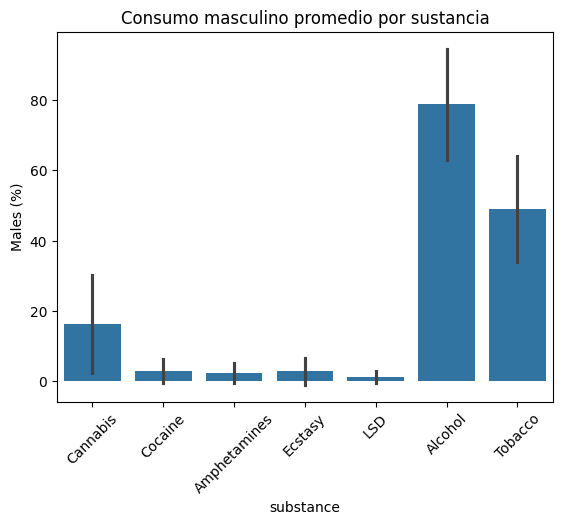

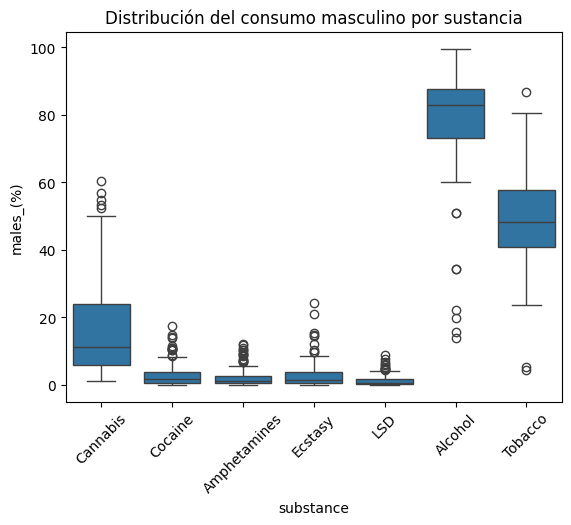

In [167]:
sns.barplot(data=df_drugs, x="substance", y="males_(%)", errorbar='sd')
plt.title("Consumo masculino promedio por sustancia")
plt.ylabel("Males (%)")
plt.xticks(rotation=45)
plt.show()

sns.boxplot(data=df_drugs, x="substance", y="males_(%)")
plt.title("Distribución del consumo masculino por sustancia")
plt.xticks(rotation=45)
plt.show()

La gráfica confirma estos patrones, mostrando distribuciones claramente diferenciadas por sustancia y una mayor dispersión en aquellas con menor consumo medio.

*Consumo femenino por sustancia*

In [154]:
df_drugs.groupby("substance")["females_(%)"].describe()

,count,mean,std,min,25%,50%,75%,max
substance,,,,,,,,
Alcohol,129.0,68.759690,20.472777,3.7,60.300,74.80,82.500,98.2
Amphetamines,143.0,1.090909,1.469066,0.0,0.100,0.50,1.350,7.1
Cannabis,166.0,9.627108,10.679300,0.0,2.125,5.25,13.375,48.8
Cocaine,151.0,1.435099,1.806477,0.0,0.250,0.80,1.750,8.1
Ecstasy,151.0,1.468874,2.288353,0.0,0.200,0.60,1.850,15.4
LSD,139.0,0.533094,0.744194,0.0,0.000,0.20,0.650,4.0
Tobacco,122.0,36.686066,14.695681,6.0,24.850,34.30,46.275,72.4


Respecto el **consumo femenino por tipo de sustancia**, se aprecia que sigue un patrón similar al de los hombres a pesar de que muestra niveles sistemáticamente más bajos:

* El alcohol sigue siendo la sustancia más consumida por las mujeres, con una media cercana al 69% que, aunque es inferior a la masculina, sigue siendo elevada.
* El tabaco presenta una media aproximada del 37%, de nuevo notablemente inferior a la observada en hombres.
* El cannabis tiene una media cercana al 10%, con alta variabilidad
* El consumo femenino de Cocaína, Éxtasis, Anfetaminas y LSD es bajo, con medianas generalmente inferiores al 1%, y menor dispersión que en el consumo masculino.

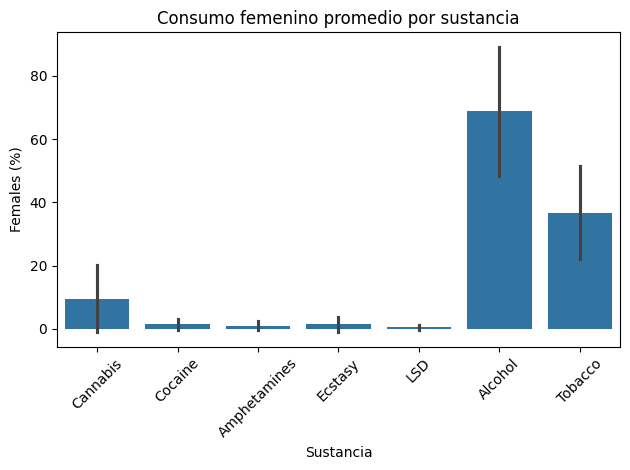

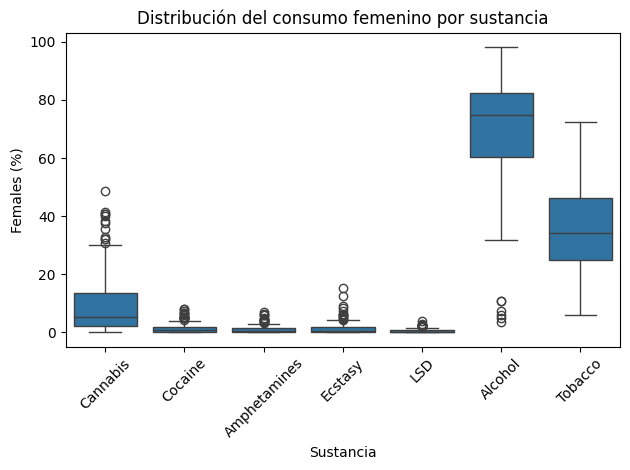

In [170]:
sns.barplot(
    data=df_drugs,
    x="substance",
    y="females_(%)",
    errorbar='sd'  # Desviación estándar como barra de error
)
plt.title("Consumo femenino promedio por sustancia")
plt.ylabel("Females (%)")
plt.xlabel("Sustancia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

sns.boxplot(
    data=df_drugs,
    x="substance",
    y="females_(%)"
)
plt.title("Distribución del consumo femenino por sustancia")
plt.ylabel("Females (%)")
plt.xlabel("Sustancia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Las gráficas muestran que, aunque existen casos puntuales de consumo elevado en mujeres, estos son menos frecuentes y menos extremos que en hombres.

Paralelamente, es necesario realizar una comparación entre las mujeres y los hombres:

* Para todas las sustancias que se han analizado, el consumo masculino es superior al femenino
* Las mayores diferencias se observan en el Alcohol, el Tabaco y el Cannabis, que, a su vez, son las que tienen los mayores niveles de consumo en los dos sexos
* En sustancias con baja prevalencia, como el LSD, las diferencias existen pero son menos pronunciadas como consecuencia de los bajos niveles generales de consumo.

En conclusión, este análisis ha mostrado que el consumo es mayor en hombres que en mujeres para todas las sustancias. Además, la elevada dispersión en algunas sustancias sugiere la influencia de factores adicionales como el país, que serán explorados en análisis posteriores.

*Sustancia y prevalencia*

In [155]:
df_drugs.groupby("substance")["prevalence_(%)"].describe()

,count,mean,std,min,25%,50%,75%,max
substance,,,,,,,,
Alcohol,132.0,73.750758,17.686176,8.6,65.825,78.4,84.4,98.9
Amphetamines,149.0,1.663758,2.091366,0.0,0.300,0.7,2.2,9.1
Cannabis,171.0,12.817544,12.108385,0.4,3.950,8.2,19.1,54.5
Cocaine,159.0,2.214465,2.617585,0.0,0.400,1.3,2.8,12.0
Ecstasy,159.0,2.201258,3.130839,0.0,0.400,0.9,2.7,18.6
LSD,148.0,0.925676,1.252922,0.0,0.100,0.4,1.3,6.6
Tobacco,125.0,42.397600,14.321698,5.3,33.400,39.0,51.0,76.3


Por lo que respecta la prevalencia en función al tipo de sustancia, los resultados muestran diferencias notables en la prevalencia en función a la sustancia que se analice:

* El alcohol tiene la mayor prevalencia de consumo con diferencia, con una media aproximada al 74% y una mediana superior al 78%. Esto muestra que se trata de una sustancia cuyo consumo está ampliamente generalizado en la población.
* El tabaco ocupa la segunda posición y tiene una prevalencia media en torno al 42%, hecho que uestra también un consumo elevado pero más heterogéneo que el alcohol.
* El cannabis tiene una prevalencia intermedia (media ≈ 13%), con una desviación estándar elevada, hecho que sugiere diferencias entre  grupos poblacionales.
* Las sustancias como la cocaína, el éxtasis, las anfetaminas y el LSD muestran prevalencias medias muy bajas, por debajo del 3%, lo que indicaría que su consumo es minoritario. No obstante, la presencia de valores máximos relativamente elevados reflejaría la existencia de contextos específicos con consumos superiores significativamente a la media.


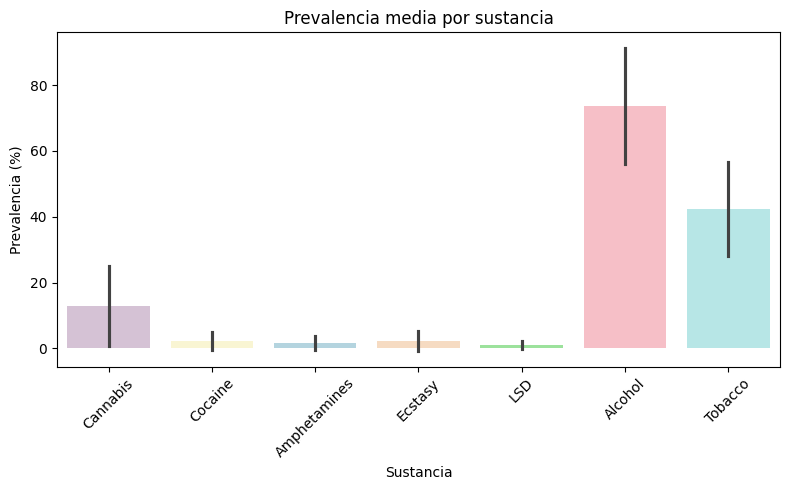

In [177]:
#BARPLOT
plt.figure(figsize=(8,5))

sns.barplot(
    data=df_drugs,
    x="substance",
    y="prevalence_(%)",
    hue="substance",
    errorbar="sd",
    palette=colores_pastel,
    legend=False
)

plt.ylabel("Prevalencia (%)")
plt.xlabel("Sustancia")
plt.title("Prevalencia media por sustancia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

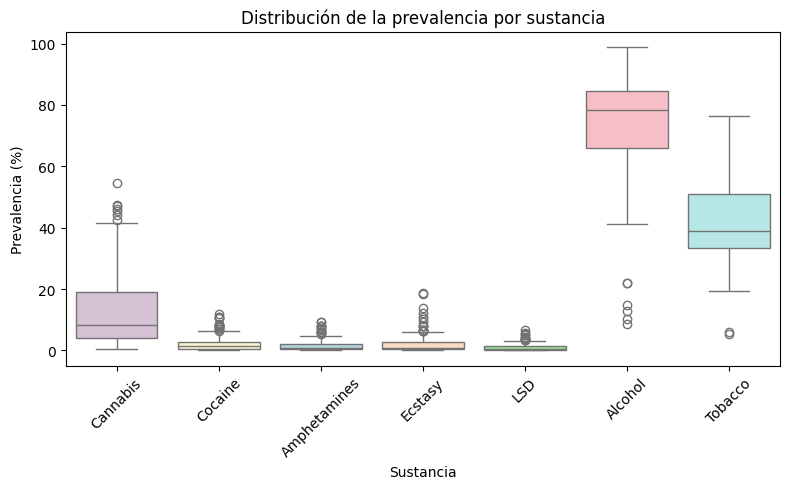

In [178]:
#BOXPLOT
plt.figure(figsize=(8,5))

sns.boxplot(
    data=df_drugs,
    x="substance",
    y="prevalence_(%)",
    hue="substance",
    palette=colores_pastel,
    legend=False
)

plt.ylabel("Prevalencia (%)")
plt.xlabel("Sustancia")
plt.title("Distribución de la prevalencia por sustancia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Las gráficas reforzarían la interpretación anterior, mostrando distribuciones diferenciadas entre sustancias y confirmando la fuerte heterogeneidad del consumo.

*Edad y prevalencia*

In [156]:
df_drugs.groupby("age")["prevalence_(%)"].describe()

,count,mean,std,min,25%,50%,75%,max
age,,,,,,,,
Adults (15-64),528.0,17.150568,27.181936,0.0,0.5,2.2,24.675,97.6
Young adults (15-34),515.0,17.976893,26.338707,0.0,0.8,3.5,27.300,98.9


Respecto la prevalencia del consumo en función al grupo de edad, se observa que los valores medios de prevalencia son similares entre adultos (15–64) y jóvenes adultos (15–34), siendo aproximadamente de 17–18%.

Asimismo, las medianas son ligeramente mayores en el grupo de jóvenes adultos, hecho que sugeriría un consumo más frecuente en este grupo, aunque la diferencia es moderada.

Además, los dos grupos tienen una dispersión elevada y unos valores máximos muy altos, mostrando que la variabilidad del consumo es independiente de la edad.

Por ende, la edad no introduciría diferencias significativas en la prevalencia total del consumo, aunque sí puede influir en el tipo de sustancia o en el consumo por sexo.

A continuación, se muestra una gráfica que complementa el estudio:

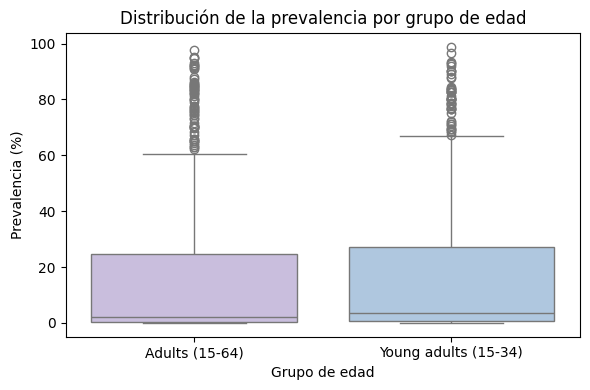

In [180]:
plt.figure(figsize=(6,4))

sns.boxplot(
    data=df_drugs,
    x="age",
    y="prevalence_(%)",
    hue="age",
    palette=["#C7B9E2", "#A7C7E7"],
    legend=False
)

plt.xlabel("Grupo de edad")
plt.ylabel("Prevalencia (%)")
plt.title("Distribución de la prevalencia por grupo de edad")
plt.tight_layout()
plt.show()

**Análisis ANOVA**

*Edad y consumo*

In [182]:
grupos = df_drugs['age'].unique()

prevalencia_por_grupo = [df_drugs[df_drugs['age'] == grupo]['prevalence_(%)'].dropna() for grupo in grupos]

f_val, p_val = stats.f_oneway(*prevalencia_por_grupo)

print("Valor F:", f_val)
print("Valor p:", p_val)

Valor F: 0.248426192331325
Valor p: 0.6182907188674204


Interpretación ANOVA: Edad vs Prevalencia del consumo

Se ha realizado un análisis ANOVA para evaluar si existen diferencias significativas en la prevalencia del consumo (prevalence_(%)) entre los dos grupos de edad: Adults (15–64) y Young adults (15–34):

* El estadístico F obtenido es 0.248, y el p-valor asociado es 0.618
* Comoe el p-valor es mucho mayor que 0.05, no se rechaza la hipótesis nula.

Por ende, no existen diferencias estadísticamente significativas en la prevalencia media del consumo entre adultos y jóvenes adultos, motivo por el cual la edad por sí sola no explicaría las variaciones en el nivel de consumo.

*Edad y consumo de hombres*

In [183]:
grupos = df_drugs['age'].unique()

prevalencia_por_grupo = [df_drugs[df_drugs['age'] == grupo]['males_(%)'].dropna() for grupo in grupos]


f_val, p_val = stats.f_oneway(*prevalencia_por_grupo)

print("Valor F:", f_val)
print("Valor p:", p_val)

Valor F: 0.053066541873767116
Valor p: 0.8178570904383988


En segundo lugar, se ha realizado un ANOVA para evaluar si existen diferencias estadísticamente significativas en el porcentaje de consumo masculino (males_(%)) entre los dos grupos de edad: Adults (15–64) y Young adults (15–34).

* El estadístico F obtenido es 0.053 y el p-valor es 0.818.
* Como que el p-valor es mucho mayor que 0.05, no se rechaza la hipótesis nula.

Por lo tanto, no existen diferencias estadísticamente significativas en el consumo entre hombres adultos y hombres jóvenes adultos, indicando que la edad no afectaría de forma significativa en el consumo de estupefacientes de los hombres.

*Edad y consumo de mujeres*

In [184]:
grupos = df_drugs['age'].unique() 

prevalencia_por_grupo = [df_drugs[df_drugs['age'] == grupo]['females_(%)'].dropna() for grupo in grupos]

f_val, p_val = stats.f_oneway(*prevalencia_por_grupo)

print("Valor F:", f_val)
print("Valor p:", p_val)

Valor F: 0.2142405250399809
Valor p: 0.6435646389013645


En tercer lugar, se ha realizado un ANOVA con el objetivo de evaluar si existen diferencias significativas en el porcentaje de consumo femenino (females_(%)) entre los dos grupos de edad: Adults (15–64) y Young adults (15–34):

* El estadístico F obtenido es 0.214 y el p-valor es 0.644.
* Igual que antes, como el p-valor es superior a 0.05, no se rechaza la hipótesis nula.

Por lo tanto, no existen diferencias estadísticamente significativas en el consumo femenino entre adultos y jóvenes adultos. Por ello e, igual que en hombres, la edad no influiría de forma relevante en el consumo de estupefacientes en mujeres


En términos generales y, en base a los tres ANOVA realizados anteriormente, se confirma que la edad no constituye un factor determinante del nivel de consumo general ni del consumo diferenciado por sexo. Por ello, las diferencias que se puedan observar entre hombres y mujeres no se encontrará condicionada por la edad.


*Sustancia y consumo de hombres*

In [185]:
grupos = df_drugs['substance'].unique()


prevalencia_por_grupo = [df_drugs[df_drugs['substance'] == grupo]['males_(%)'].dropna() for grupo in grupos]


f_val, p_val = stats.f_oneway(*prevalencia_por_grupo)

print("Valor F:", f_val)
print("Valor p:", p_val)

Valor F: 1290.2007844662353
Valor p: 0.0


Por su parte, se ha realizado un ANOVA para evaluar si existen diferencias estadísticamente significativas en el porcentaje de consumo masculino (males_(%)) entre los diversos tipos de sustancia:

* El estadístico F obtenido es 1290.20 y el p-valor es 0.0 (p < 0.001).
* Dado que el p-valor es muy inferior a 0.05, se rechaza la hipótesis nula.

Por ello, existen diferencias significativas en el consumo masculino según la sustancia, confirmando, así, lo observado previamente en el análisis descriptivo:
* Alcohol y tabaco: tienen medias de consumo masculino muy elevadas.
* Cannabis: consumo intermedio.
* Cocaína, Éxtasis, Anfetaminas y LSD: consumos mucho más bajos.

Por ende, el tipo de sustancia tiene un impacto significativo en el consumo masculino: la diferencia en las medias explicaría el valor elevado del estadístico F, informando que el tipo de sustancia constituye un factor determinante en el consumo de los hombres.

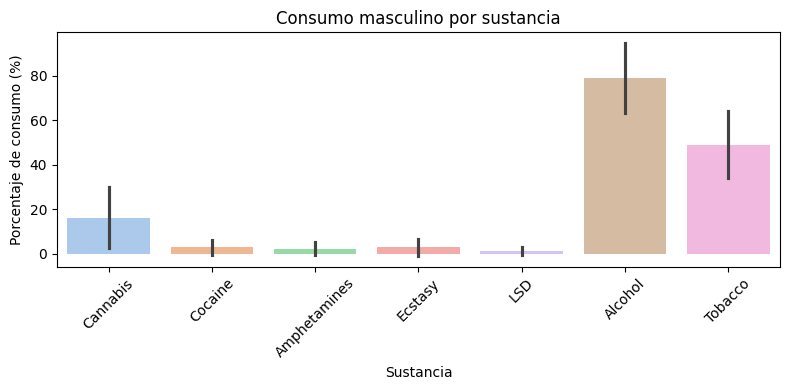

In [196]:
plt.figure(figsize=(8,4))

sns.barplot(
    data=df_drugs,
    x="substance",
    y="males_(%)",
    hue="substance",
    errorbar="sd",
    palette="pastel",
    legend=False
)

plt.title("Consumo masculino por sustancia")
plt.ylabel("Porcentaje de consumo (%)")
plt.xlabel("Sustancia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

La gráfica muestra la prevalencia media del consumo de hombres según el tipo de sustancia, indicando diferencias muy claras entre ellas. El alcohol destaca de forma notable como la sustancia con mayor nivel de consumo masculino, en segundo lugar se sitúa el tabaco, que también presenta valores elevados, aunque por debajo del alcohol.

El cannabis ocupa una posición intermedia, con un consumo masculino apreciable pero menor que el observado en alcohol y tabaco. Por el contrario, las sustancias ilícitas como la cocaína, éxtasis, anfetaminas y LSD tienen niveles de consumo masculino más bajos, con medias muy reducidas en comparación con las sustancias legales.

Así, se pone de manifiesto que el consumo masculino no es homogéneo entre sustancias: está condicionado por el tipo de droga, destacando claramente las sustancias legales frente a las ilegales.

*Sustancia y consumo de mujeres*

In [186]:
grupos = df_drugs['substance'].unique() 


prevalencia_por_grupo = [df_drugs[df_drugs['substance'] == grupo]['females_(%)'].dropna() for grupo in grupos]


f_val, p_val = stats.f_oneway(*prevalencia_por_grupo)

print("Valor F:", f_val)
print("Valor p:", p_val)

Valor F: 903.5849438036058
Valor p: 0.0


Asimismo, se ha realizado un ANOVA para evaluar si existen diferencias estadísticamentee significativas en el porcentaje de consumo femenino (females_(%)) entre los distintos tipos de sustancia:

* El estadístico F obtenido es 903.58 y el p-valor es 0.0 (p < 0.001).
* Como el p-valor es menor que 0.05, se rechaza la hipótesis nula.

Por ello, se puede confirmar que existen diferencias significativas en el consumo femenino según la sustancia. Concretamente, las sustancias con mayor consumo medio entre mujeres son el Alcohol y el Tabaco, seguidas del Cannabis, mientras que la Cocaína, el Éxtasis, las Anfetaminas y el LSD tienen niveles mucho más bajos.

Esto confirmaría los patrones descriptivos observados anteriormente y muestra que, por ende, la sustancia es un factor determinante del nivel de consumo en mujeres.

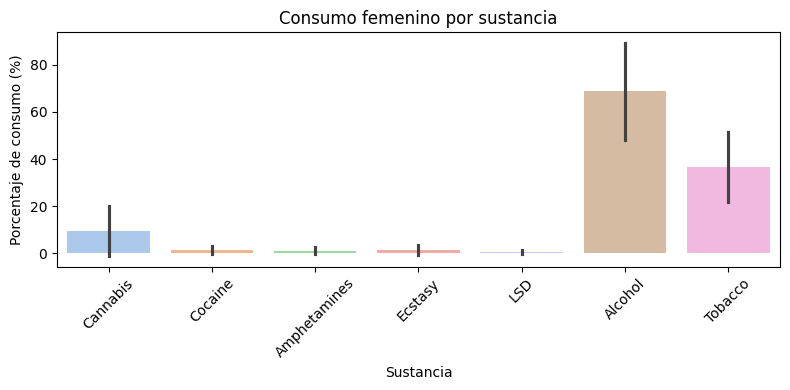

In [197]:
plt.figure(figsize=(8,4))

sns.barplot(
    data=df_drugs,
    x="substance",
    y="females_(%)",
    hue="substance",
    errorbar="sd",
    palette="pastel",
    legend=False
)

plt.title("Consumo femenino por sustancia")
plt.ylabel("Porcentaje de consumo (%)")
plt.xlabel("Sustancia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

La gráfica muestra la prevalencia media del consumo en mujeres según el tipo de sustancia, indicando un patrón claramente diferenciado entre sustancias. Igual que en el consumo masculino, el alcohol es la sustancia con mayor nivel de consumo femenino, seguida del tabaco, aunque en ambos casos con valores medios inferiores a los observados en hombres.

El cannabis tiene un consumo femenino moderado, situándose en una posición intermedia, mientras que las sustancias ilícitas muestran niveles de consumo muy bajos, con medias reducidas y próximas a cero en muchos casos.

Así, la gráfica evidencia que el consumo femenino está fuertemente condicionado por el tipo de sustancia, con una clara predominancia de las sustancias legales y un consumo muy reducido de drogas ilegales.

En términos generales, tanto en mujeres como en hombres, el tipo de sustancia presenta un efecto significativo sobre el porcentaje de consumo.

*Sustancia y prevalencia de consumo*

In [187]:
grupos = df_drugs['substance'].unique() 

prevalencia_por_grupo = [df_drugs[df_drugs['substance'] == grupo]['prevalence_(%)'].dropna() for grupo in grupos]


f_val, p_val = stats.f_oneway(*prevalencia_por_grupo)

print("Valor F:", f_val)
print("Valor p:", p_val)

Valor F: 1185.687259210663
Valor p: 0.0


Por otro lado, se ha analizado un ANOVA con el objetivo de analizar si existen diferencias estadísticamente significativas en la prevalencia del consumo total (prevalence_(%)) entre los distintos tipos de sustancia:

* El estadístico F obtenido es 1185.69 y el p-valor es 0.0 (p < 0.001)
* Como el p-valor es mucho menor que 0.05, se rechaza la hipótesis nula.

Por ende, se confirma que existen diferencias significativas en la prevalencia de consumo según la sustancia: el alcohol y el Tabaco tienen las mayores prevalencias, mientras que el Cannabis presenta un nivel intermedio, y la Cocaína, el Éxtasis, las Anfetaminas y el LSD tienen prevalencias bajas. De esta forma, se aprecia que el tipo de sustancia es clave en la frecuencia de consumo en la población estudiada.

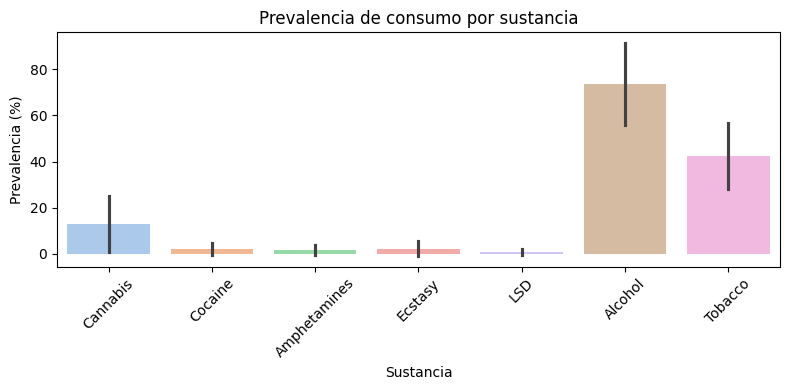

In [199]:
plt.figure(figsize=(8,4))

sns.barplot(
    data=df_drugs,
    x="substance",
    y="prevalence_(%)",
    hue="substance",
    errorbar="sd",
    palette="pastel",
    legend=False
)

plt.title("Prevalencia de consumo por sustancia")
plt.ylabel("Prevalencia (%)")
plt.xlabel("Sustancia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

La gráfica muestra la prevalencia media total de consumo según el tipo de sustancia, mostrando diferencias marcadas entre ellas. El alcohol destaca claramente como la sustancia con mayor prevalencia de consumo, situándose por encima del resto. En segundo lugar está el tabaco, que también tiene valores elevados, aunque inferiores a los del alcohol.

El cannabis tiene una posición intermedia, con una prevalencia apreciable pero menor que la de las sustancias legales. 

Por el contrario, las drogas ilícitas como cocaína, éxtasis, anfetaminas y LSD muestran niveles de prevalencia muy bajos, con valores medios reducidos en comparación con alcohol, tabaco y cannabis.

En conjunto, la gráfica manifiesta que la prevalencia del consumo está determinada por el tipo de sustancia, con una diferenciación entre sustancias legales y la mayoría de drogas ilegales.

*Consumo por edad, prevalencia y sustancia*

In [188]:
df_age = df_drugs[df_drugs["recall_period"] == "Last year"]

df_age = (
    df_age.sort_values("survey_year")
    .groupby(["substance", "age"])
    .tail(1)
)

grupos_edad = [
    df_age[df_age["age"] == edad]["prevalence_(%)"]
    for edad in df_age["age"].unique()
]

f_val, p_val = stats.f_oneway(*grupos_edad)

print("ANOVA por edad")
print("F:", f_val)
print("p:", p_val)

ANOVA por edad
F: 0.01492350829328512
p: 0.9047928441949864


Por su parte, para analizar si existen diferencias estadísticamente significativas en la prevalencia del consumo durante el último año entre los dos grupos de edad, considerando todas las sustancias, se ha realizado un análisis ANOVA:

* El estadístico F obtenido es 0.015 y el p-valor es 0.905.
* Como el p-valor es mucho mayor que 0.05, no se rechaza la hipótesis nula de igualdad de medias entre grupos.

Por ello, puede establecerse que no existen diferencias significativas en la prevalencia de consumo anual según la edad, indicando que ni la edad ni el tipo de sustancia generan cambios relevantes en el consumo anual entre adultos y jóvenes adultos. Por lo tanto, la edad no constituye un factor determinante del consumo de drogas.

*Sustancias y prevalencia*

In [190]:
grupos_sustancia = [
    df_age[df_age["substance"] == sust]["prevalence_(%)"]
    for sust in df_age["substance"].unique()
]

f_val, p_val = stats.f_oneway(*grupos_sustancia)

print("ANOVA por sustancia")
print("F:", f_val)
print("p:", p_val)

ANOVA por sustancia
F: 300.83851424750475
p: 4.407528212598659e-08


Asimismo, se ha realizado un ANOVA para evaluar si existen diferencias significativas en la prevalencia de consumo entre las distintas sustancias:

* El estadístico F es 300.84 y el p-valor es 4.41×10⁻⁸ (p < 0.001).
* Como el p-valor es mucho menor que 0.05, se rechaza la hipótesis nula.

Así, existen diferencias significativas en la prevalencia del consumo en función a la sustancia. Tal y como se apreció en el análisis descriptivo:

* Alcohol y Tabaco tienen prevalencias muy elevadas.
* Cannabis muestra valores intermedios.
* Cocaína, Éxtasis, Anfetaminas y LSD tienen prevalencias bajas.

Esto indicaría que el tipo de sustancia constituye un factor determinante del consumo, incluso cuando se considera únicamente el último año.

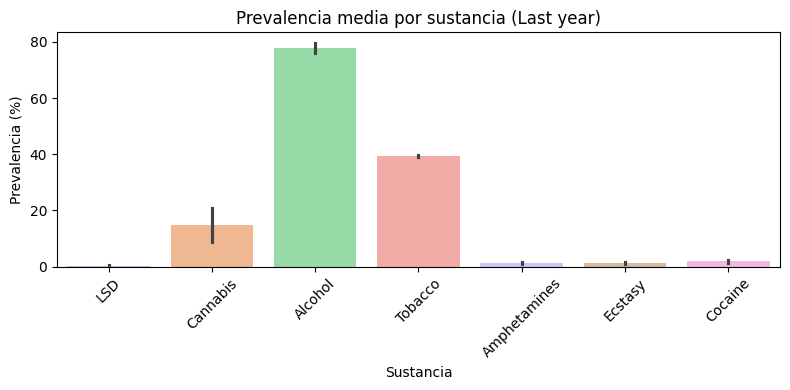

In [191]:
plt.figure(figsize=(8,4))

sns.barplot(
    data=df_age,
    x="substance",
    y="prevalence_(%)",
    errorbar="sd",
    hue="substance",
    palette="pastel",
    legend=False
)

plt.title("Prevalencia media por sustancia (Last year)")
plt.ylabel("Prevalencia (%)")
plt.xlabel("Sustancia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Tal y como arrojaban los resultados anteriores, en la gráfica puede apreciarse un contraste dedstacable en el consumo de cada sustancia. Se pone de manifiesto, así, que el nivel de consumo no es homogéneo entre sustancias, sino que varía según el tipo de droga. Concretamente, sustancias como alcohol y tabaco presentan prevalencias medias superiores en comparación con otras sustancias como LSD, anfetaminas, cocaína o éxtasis, cuyo consumo es menor.


La magnitud del estadístico F anteriormente mencionado refuerza esta conclusión, sugiriendo que el tipo de sustancia es un factor determinante en la explicación de las diferencias observadas en los niveles de consumo. Este hallazgo es coherente con los resultados descriptivos previos y con la visualización gráfica, donde se aprecian claras diferencias entre sustancias legales y otras drogas de uso menos extendido.


**Conclusión**

El análisis bivariante nos ha permitido analizar cómo las variables edad y tipo de sustancia (categóricas) se relacionan con las variables numéricas prevalencia del consumo y el consumo desagregado por sexo (males_(%), females_(%)).

En primer lugar, al estudiar la variable **edad**, los ANOVA realizados tanto sobre la prevalencia global como sobre el consumo masculino y femenino no mostraron diferencias significativas entre los grupos Adults (15–64) y Young adults (15–34). Los estadísticos F fueron muy bajos y los p-valores muy altos, mostrando, así que la edad no influye significativamente en la frecuencia de consumo ni en la proporción de hombres y mujeres que consumen. Esto se ve reforzado por los gráficos presentados, los cuales muestran medias y medianas similares entre ambos grupos. Así, se puede determinar que la edad no constituye un factor determinante del consumo de drogas en los datos analizados.

En segundo lugar, la variable **sustancia** tiene un efecto significativo sobre todas las medidas de consumo. Los ANOVA informan diferencias  significativas entre sustancias, tanto en la prevalencia global como en los consumos diferenciados por sexo. Los gráficos muestran que el Alcohol y el Tabaco tienen los consumos más elevados, mientras que el Cannabis se sitúa en niveles intermedios y la Cocaína, Éxtasis, Anfetaminas y LSD tienen valores notablemente más bajos. Además, dentro de cada sustancia, los hombres consumen más que las mujeres, confirmando un patrón consistente a lo largo de todas las drogas analizadas. 

En resumen, los resultados del análisis bivariante permiten concluir que:

* La edad no influye significativamente en la prevalencia ni en el consumo por sexo.
* La sustancia es un factor clave que explica la variabilidad en el consumo.
* Los hombres consumen más que las mujeres de manera consistente en todas las sustancias.



## 1.3 ANÁLISIS MULTIVARIANTE

En el presente apartado se realiza un análisis multivariante de diversas variables con el objetivo, entre otros, de comparar la prevalencia de consumo entre países respecto la sustancia, la edad, el consumo femenino y masculino

In [367]:
pivot1 = df_drugs.pivot_table(
    values="prevalence_(%)",
    index="females_(%)",
    columns="substance"
)

In [ ]:
pivot2 = df_drugs.pivot_table(
    values="prevalence_(%)",
    index="males_(%)",
    columns="substance"
)

In [ ]:
pivot3 = df_drugs.pivot_table(
    values="prevalence_(%)",
    index="age",
    columns="substance"
)

Vamos a ver datos descriptivos para resumir  cómo se distribuyen las variables numéricas por grupo de edad:

In [291]:
cols_num = ["prevalence_(%)", "males_(%)", "females_(%)"]

df_summary = (
    df_drugs_no_na
    .groupby("age")[cols_num]
    .agg(["mean", "median", "std"])
)

df_summary

prevalence_(%)                    males_(%)         \
                               mean median        std       mean median   
age                                                                       
Adults (15-64)            17.220588   2.05  27.525137  19.497899   2.95   
Young adults (15-34)      18.176160   3.40  26.674599  20.304219   4.55   

                                females_(%)                    
                            std        mean median        std  
age                                                            
Adults (15-64)        29.622118   15.018277   1.30  25.736865  
Young adults (15-34)  28.140220   16.048734   2.35  25.442070

Al analizar la **prevalencia** media de consumo, se observa que los jóvenes adultos de 15 a 34 años consumen ligeramente más drogas que los adultos de 15 a 64 años, con un promedio de 18,18% (frente a 17,22%). A pesar de que la diferencia parece pequeña, su mediana también es mayor (3,40% frente a 2,05%), hecho que indica que el patrón central del consumo tiende a ser más alto en los jóvenes. Por su parte, la desviación estándar es alta en ambos grupos (superior al 26%), revelando que dentro de cada grupo existen personas con niveles de consumo muy dispares, lo que refleja una gran heterogeneidad y la presencia de subgrupos con consumos intensos. 

Analizando por **género**, los hombres jóvenes adultos presentan un consumo medio de 20,30% frente a 19,50% en los adultos, lo que refuerza la idea de que los hombres tienden a consumir más que las mujeres y que esta diferencia es más marcada en los grupos jóvenes. La mediana de los hombres jóvenes es también superior (4,55% frente a 2,95%), indicando que más de la mitad de los individuos jóvenes consumen más que la mitad de los adultos. En las mujeres, las jóvenes adultas presentan un consumo medio de 16,05%, algo superior al 15,02% de las adultas, aunque la diferencia es menor que en los hombres, lo que sugiere que el efecto de la edad sobre el consumo es más evidente en hombres. La desviación estándar elevada para ambos sexos indica que, aunque los valores medios son bajos, existen casos de consumo muy alto que elevan la dispersión, reflejando comportamientos heterogéneos dentro de cada grupo. 

En conjunto, estos resultados permiten interpretar que la edad tiene un efecto moderado sobre el consumo total, con una tendencia de mayor consumo entre los jóvenes adultos, especialmente hombres, y que dentro de cada grupo existe una gran diversidad de hábitos de consumo, lo que podría ser relevante para diseñar políticas de prevención o intervenciones dirigidas a los subgrupos con mayor riesgo.

Para facilitar analisis  posteriores, hacemos analisis descriptivo

In [292]:
df_drugs_num = df_drugs.select_dtypes(include = ["float","int"])
df_drugs_num.columns

Index(['survey_year', 'prevalence_(%)', 'sample_size', 'males_(%)',
       'females_(%)', 'gender_gap'],
      dtype='object')

Tabla cruzada para hacer el análisis y comparar simultáneamente:
* Edad (age)
* Tipo de sustancia (substance)
* Género (gender)
* Prevalencia del consumo (prevalence)

In [293]:
df_gender2 = df_drugs.melt(
    id_vars=["substance", "age"],
    value_vars=["males_(%)", "females_(%)", "prevalence_(%)"],
    var_name="gender",
    value_name="prevalence"
)

df_gender2["gender"] = df_gender2["gender"].str.replace("_(%)", "", regex=False)
df_gender2["prevalence"] = pd.to_numeric(df_gender2["prevalence"], errors="coerce")

df_gender2.head()

pivot_gender2 = df_gender2.pivot_table(
    values="prevalence",
    index="age",
    columns=["substance", "gender"],
    aggfunc="mean"
)

pivot_gender2.head()

substance               Alcohol                       Amphetamines            \
gender                  females      males prevalence      females     males   
age                                                                            
Adults (15-64)        68.642647  80.073529  74.226471     0.847945  1.893243   
Young adults (15-34)  68.890164  77.549180  73.245312     1.344286  2.594366   

substance                         Cannabis                         Cocaine  \
gender               prevalence    females      males prevalence   females   
age                                                                          
Adults (15-64)         1.340000   7.317647  13.084706   9.952874  1.118182   
Young adults (15-34)   1.991892  12.050617  19.522222  15.784524  1.764865   

substance             ...              Ecstasy                            LSD  \
gender                ... prevalence   females     males prevalence   females   
age                   ...                                                       
Adults (15-64)        ...   1.798750  1.079221  2.218987   1.615000  0.430986   
Young adults (15-34)  ...   2.635443  1.874324  3.393421   2.794937  0.639706   

substance                                    Tobacco                        
gender                   males prevalence    females      males prevalence  
age                                                                         
Adults (15-64)        1.058108   0.727027  35.854687  49.248438   42.41875  
Young adults (15-34)  1.450704   1.124324  37.603448  48.782759   42.37541  

[2 rows x 21 columns]

Según se aprecia, los hombres presentan una prevalencia más alta que las mujeres en casi todas las sustancias y edades. Por ejemplo, en adultos (15-64), la prevalencia media de alcohol es de 80,07% para hombres frente a 68,64% para mujeres. En jóvenes adultos (15-34) también se mantiene esta diferencia, aunque ligeramente menor (77,55% vs 68,89%).

En el cannabis, la diferencia por género es más marcada en jóvenes adultos, con hombres consumiendo un promedio de 19,52% frente a 12,05% en mujeres.

Sustancias como anfetaminas, cocaina o éxtasis muestran que los hombres consumen aproximadamente el doble que las mujeres en los dos grupos de edad, aunque la prevalencia absoluta sigue siendo baja.

La comparación entre edades indica que, para la mayoría de sustancias, los jóvenes adultos tienen una prevalencia superior al grupo de adultos, sobre todo en drogas recreativas como Cannabis, Cocaína y extasis, reflejando, así, que los hábitos de consumo más experimentales o de riesgo se concentran en el grupo más joven.


En conjunto, se ha apreciado que el género y la edad son factores respecto la preevalencia del consumo de drogas, con los hombres y los jóvenes adultos mostrando sistemáticamente prevalencias más altas, y con ciertas sustancias presentan diferencias de consumo más marcadas que otras. Esta representación facilita identificar rápidamente los grupos de mayor riesgo y las sustancias más relevantes para posibles intervenciones o estudios más detallados.

Por otro lado, vamos a identificar:
* En qué drogas la diferencia entre hombres y mujeres es mayor
* Qué grupo de edad tiene esa mayor brecha

In [294]:
topN = 10
rank_gap = (
    df_drugs.dropna(subset=["gender_gap"])
    .sort_values("gender_gap", ascending=False)
    .groupby("substance")
    .head(topN)
)

rank_gap[["substance", "age", "gender_gap"]]

,substance,age,gender_gap
468,Alcohol,Adults (15-64),38.4
469,Alcohol,Young adults (15-34),35.9
592,Alcohol,Adults (15-64),32.2
182,Tobacco,Adults (15-64),30.5
633,Tobacco,Adults (15-64),29.7
...,...,...,...
318,LSD,Adults (15-64),3.2
624,LSD,Young adults (15-34),3.1
461,LSD,Young adults (15-34),3.0
321,LSD,Young adults (15-34),2.8


En este análisis se aprecia que el alcohol muestra las diferencias más altas entre géneros, alcanzando hasta un 38,4% en adultos (15-64) y 35,9% en jóvenes adultos (15-34). Esto indica que en el consumo de alcohol, los hombres consumen considerablemente más que las mujeres en ambos grupos de edad.

El tabaco también tiene brechas notables, con valores que superan el 29% en adultos, reflejando una tendencia similar: los hombres son los principales consumidores.

Por otro lado, sustancias como el LSD presentan diferencias mucho más bajas, en torno al 2,8–3,2%, indicando que el consumo de esta droga está más equilibrado entre hombres y mujeres.

En términos generales, este análisis permite identificar qué sustancias presentan las mayores desigualdades de género y en qué grupos de edad se concentran. Los resultados refuerzan el patrón observado en los análisis anteriores: los hombres tienden a tener mayor prevalencia de consumo que las mujeres, y esta diferencia es particularmente marcada en drogas legales o socialmente más accesibles como alcohol y tabaco, mientras que las drogas menos frecuentes presentan brechas de género mucho menores.

**Comparación por edad**

In [3]:
df_age = df_drugs[df_drugs["recall_period"] == "Last year"]


df_age = (
    df_age.sort_values("survey_year")
    .groupby(["substance", "age"])
    .tail(1)
)

# 3. Tabla de comparación por edad
pivot_age = df_age.pivot_table(
    values="prevalence_(%)",
    index="substance",
    columns="age",
    aggfunc="mean"
)

# 4. Diferencia entre jóvenes y adultos
pivot_age["young_minus_adults"] = (
    pivot_age["Young adults (15-34)"] - pivot_age["Adults (15-64)"]
)

print(pivot_age)

age           Adults (15-64)  Young adults (15-34)  young_minus_adults
substance                                                             
Alcohol                 76.4                  78.9                 2.5
Amphetamines             0.9                   1.4                 0.5
Cannabis                10.6                  19.1                 8.5
Cocaine                  1.5                   2.2                 0.7
Ecstasy                  1.0                   1.5                 0.5
LSD                      0.2                   0.4                 0.2
Tobacco                 39.0                  39.5                 0.5


En este análisis se ha comparado la prevalencia de consumo en el último año entre jóvenes adultos (15–34 años) y adultos (15–64 años) para cada sustancia. 

Los resultados arrojan una prevalencia mayor en todas las sustancias en el grupo de jóvenes adultos, aunque la magnitud de la diferencia varía  según el estupefaciente:

* El alcohol presenta una prevalencia muy elevada en ambos grupos, con un 78,9% en jóvenes frente a 76,4% en adultos, indicando, así que el consumo de alcohol está ampliamente extendido en toda la población, aunque ligeramente más presente en edades más jóvenes.

* La diferencia más destacada se observa en el cannabis, donde los jóvenes adultos tienen una prevalencia del 19,1%, frente al 10,6% en adultos. La diferencia muesra un patrón generacional, sugiriendo que el consumo de cannabis está mucho más concentrado en edades tempranas.

* En sustancias como cocaína, éxtasis y anfetaminas, las diferencias son más moderadas. No obstante, en todos los casos los jóvenes tienen una prevalencia superior

* El LSD presenta niveles de consumo muy bajos en ambos grupos, con una diferencia mínima de 0,2 puntos porcentuales, lo que indica un consumo residual y poco extendido independientemente de la edad.

* En el caso del tabaco, la prevalencia es prácticamente idéntica entre jóvenes (39,5%) y adultos (39,0%), sugiriendo que el consumo de tabaco está mucho menos marcado por la edad que el de otras sustancias, posiblemente debido a su carácter legal, su larga tradición de consumo y la persistencia del hábito a lo largo del ciclo vital.

En conjunto, este análisis pone de manifiesto que la edad es un factor relevante en la prevalencia del consumo, especialmente para sustancias como el cannabis y, en menor medida, el alcohol y las drogas recreativas. Mientras que algunas sustancias muestran un consumo claramente más juvenil, otras como el tabaco y el alcohol presentan patrones más homogéneos entre grupos de edad.

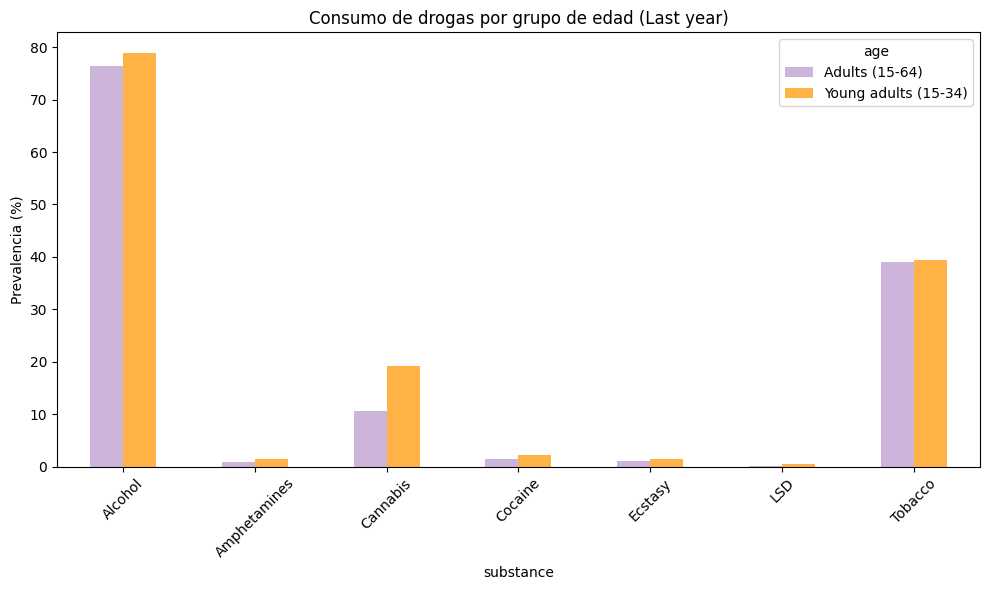

In [4]:
pivot_age[["Adults (15-64)", "Young adults (15-34)"]].plot(
    kind="bar",
    figsize=(10, 6),
    color=["#CDB4DB", "#FFB347"]
)

plt.ylabel("Prevalencia (%)")
plt.title("Consumo de drogas por grupo de edad (Last year)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Esta gráfica representa visualmente el análisis anteriormente mencionado: la prevalencia media de consumo en el último año entre adultos y jóvenes para cada sustancia.

* El alcohol y el tabaco presentan valores elevados y similares en ambos grupos (consumo ampliamente extendido)
* El cannabis destaca por mostrar una prevalencia mucho mayor en jóvenes adultos
* En el resto de sustancias, aunque los niveles de consumo son bajos, se aprecia de forma consistente un mayor consumo entre jóvenes, lo que sugiere una mayor experimentación en edades tempranas.

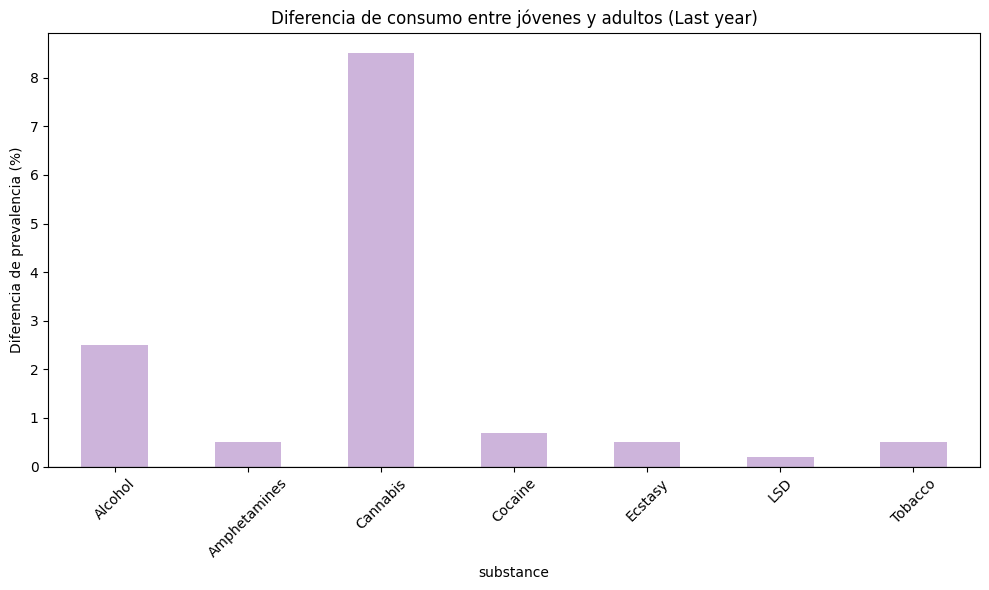

In [308]:
pivot_age["young_minus_adults"].plot(
    kind="bar",
    figsize=(10, 6),
    color="#CDB4DB"
)

plt.axhline(0, color="gray", linewidth=1)
plt.ylabel("Diferencia de prevalencia (%)")
plt.title("Diferencia de consumo entre jóvenes y adultos (Last year)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Esta gráfica muestra directamente la diferencia de consumo entre jóvenes y adultos para cada sustancia. El cannabis presenta la mayor diferencia positiva, confirmando que su consumo es significativamente más frecuente entre jóvenes. El alcohol y el tabaco muestran diferencias muy reducidas, lo que indica patrones de consumo similares entre ambos grupos de edad. Las demás sustancias presentan diferencias pequeñas pero positivas, reforzando la idea de que el consumo tiende a concentrarse ligeramente en edades más jóvenes, aunque sin grandes brechas generacionales.

*Conclusión*

En conclusión, el consumo de drogas en función de la edad muestra que el grupo de jóvenes adultos (15–34 años) presenta, de forma sistemática, una mayor prevalencia de consumo en comparación al grupo de adultos (15–64 años), aunque la magnitud de esta diferencia varía significativamente según la sustancia.

La diferencia más relevante se observa en el consumo de cannabis (prevalencia en jóvenes notablemente superior a la de los adultos, indicando un patrón generacional). En el caso del alcohol y el tabaco, las prevalencias son muy elevadas en ambos grupos de edad y las diferencias entre jóvenes y adultos son reducidas (consumo generalizado y persistente a lo largo del ciclo vital).

Para el resto de sustancias analizadas los niveles de consumo son bajos en términos absolutos, pero hay una mayor prevalencia entre los jóvenes adultos.

**Correlaciones**

A continnuación se identificarán correlaciones entre las variables numéricas 

In [309]:
corr_matrix = df_drugs.corr(numeric_only= True)
corr_matrix

,survey_year,prevalence_(%),sample_size,males_(%),females_(%),gender_gap
survey_year,1.000000,-0.116005,0.125009,-0.126986,-0.138226,-0.070798
prevalence_(%),-0.116005,1.000000,0.041694,0.995688,0.994642,0.539642
sample_size,0.125009,0.041694,1.000000,0.041001,0.041293,0.021161
males_(%),-0.126986,0.995688,0.041001,1.000000,0.980873,0.615283
females_(%),-0.138226,0.994642,0.041293,0.980873,1.000000,0.450074
gender_gap,-0.070798,0.539642,0.021161,0.615283,0.450074,1.000000


La matriz de correlaciones nos permite estudiar de manera conjunta la relación entre la prevalencia total de consumo, el consumo por sexo, la brecha de género, el año de la encuesta y el tamaño muestral, ofreciendo una visión global del papel del género en los patrones de consumo.

En primer lugar, se observa una correlación muy elevada alta entre la prevalencia total y el consumo masculino (0,996) y femenino (0,995). Este resultado es coherente y esperable, ya que la prevalencia total está directamente determinada por los niveles de consumo de ambos sexos. La ligera mayor correlación con el consumo masculino sugiere que, en el conjunto del dataset, las variaciones en la prevalencia total están algo más influenciadas por el consumo de los hombres.

La brecha de género (gender_gap) muestra una correlación positiva moderada con la prevalencia total (0,540) y una correlación más fuerte con el consumo masculino (0,615) que con el femenino (0,450). Esto indica que, a medida que aumenta el nivel global de consumo, tiende a ampliarse la diferencia entre hombres y mujeres, siendo el consumo masculino el principal motor de esta brecha. En otras palabras, en contextos de mayor consumo, los hombres incrementan su consumo en mayor proporción que las mujeres.

En resumen, se confirme que el género desempeña un papel clave en la estructura del consumo de estupefacientes, con una prevalencia global estrechamente ligada al consumo masculino y con una brecha de género que se amplía en contextos de mayor consumo. 

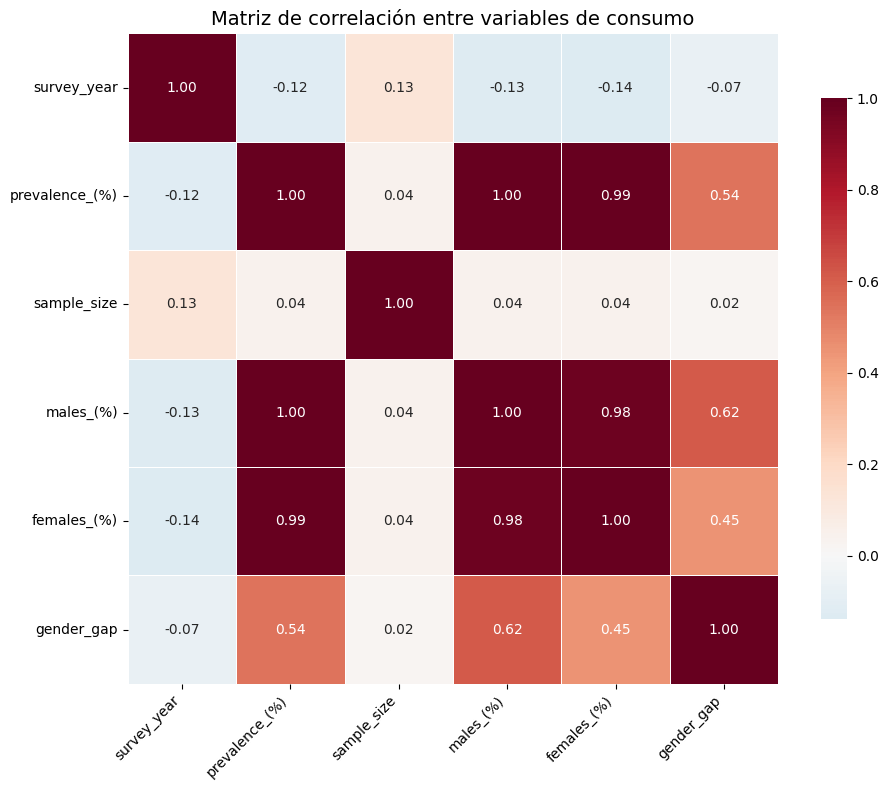

In [311]:
plt.figure(figsize=(10, 8))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",      
    center=0,          
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Matriz de correlación entre variables de consumo", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Respecto la gráfica, se destaca que la prevalencia del consumo (prevalence__(%)) tiene correlaciones altas con males_(%) (0.996) y females_(%) (0.995), lo que refleja que la prevalencia total del consumo está prácticamente determinada por los porcentajes de consumo por género. La correlación con gender_gap es moderada (0.540), lo que indica que aunque el género influye en la prevalencia total, aunque las diferencias entre hombres y mujeres no explican por completo la variabilidad.

Entre males_(%) y females_(%), la correlación es alta (0.981), lo que sugiere que en las sustancias estudiadas, cuando el consumo masculino es alto, el femenino también tiende a ser relativamente alto, aunque en menor magnitud, dado que gender_gap refleja la diferencia real entre ambos.

**Genero, edad y sustancia**

En este apartado se ha estudiado cómo varían los porcentajes de prevalencia de consumo de drogas entre hombres y mujeres en función de la edad y del tipo de sustancia. Se ha analizado simultáneamente la influencia de la edad y de la clase de droga sobre las variables dependientes males_(%) y females_(%), incluyendo además la posible interacción entre edad y sustancia para identificar si el efecto de la edad difiere según el tipo de droga. 

In [313]:
df_mv = df_drugs[df_drugs["recall_period"]=="Last year"].copy()

y_vars = ['males_(%)','females_(%)']


formula = 'Q("males_(%)") + Q("females_(%)") ~ C(age) + C(substance) + C(age):C(substance)'

manova = MANOVA.from_formula(formula, data=df_mv)
result = manova.mv_test()
print(result)

                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept         Value  Num DF  Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda  0.0833 2.0000 338.0000 1859.2742 0.0000
         Pillai's trace  0.9167 2.0000 338.0000 1859.2742 0.0000
 Hotelling-Lawley trace 11.0016 2.0000 338.0000 1859.2742 0.0000
    Roy's greatest root 11.0016 2.0000 338.0000 1859.2742 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
            C(age)         Value  Num DF  Den DF  F Value Pr > F
----------------------------------------------------------------
             Wilks' lambda 0.9902 2.0000 338.0000  1.6690 0.1900
            Pillai's trace 0.0098 2.0000 338.

En términos generales, el análisis de los tests multivariantes muestran valores de F muy elevados y un p-valor igual a 0, confirmando, así, que el modelo global es estadísticamente significativo. De esta forma, el modelo puede explicar diferencias en los porcentajes de consumo de hombres y mujeres.

1. **Edad (C(age))**
El efecto que tiene la edad sobre los consumos de hombres y mujeres no es estadísticamente significativo (Wilks’ lambda = 0.9902 y p-valor = 0.19). Esto muestra que, considerando conjuntamente las variables de consumo de hombres y mujeres, no hay diferencias entre los adultos y jóvenes adulots respecto la prevalencia del consumo.  Por ende, la edad por sí sola no es un factor determinante del consumo.

2. **Sustancia (C(substance))**
El efecto del tipo de sustancia es notablemente significativo (Wilks’ lambda = 0.0814, p < 0.001). Esto indica que el tipo de stupefaciente tiene un impacto significativo en los porcentajes de consumo tanto en hombres como en mujeres. Esto es, la prevalencia de consumo difiere significativamente en función de la sustancia.

3. **Interacción Edad × Sustancia (C(age):C(substance))**
La interacción entre la edad y la sustancia muestra valores cercanos al nivel de significación convencional: Wilks’ lambda = 0.9427 con p = 0.0657 y Pillai’s trace = 0.0576 con p = 0.068. Esto sugeriría que el efecto de la edad podría variar según la sustancia, aunque no alcanza un nivel de significación estadística estricto (p < 0.05) en la mayoría de los tests. No obstante, Roy’s greatest root da p = 0.0065, indicando que para algunas combinaciones de edad y sustancia sí existe un efecto significativo. En este caso, probablemente refleje que los jóvenes adultos consumen más ciertas drogas como cannabis o cocaína en comparación con adultos, mientras que para otras sustancias como alcohol o tabaco, las diferencias por edad son menores.

En resumen, el tipo de sustancia es el factor más determinante para explicar las diferencias en consumo entre hombres y mujeres, mientras que la edad por sí sola no tiene un efecto fuerte, aunque su interacción con la sustancia podría ser relevante en ciertos casos. 
En términos prácticos, podemos decir que los hombres y las mujeres difieren en sus porcentajes de consumo dependiendo del tipo de droga, y que algunas diferencias entre jóvenes y adultos se acentúan para ciertas sustancias como cannabis y cocaína, aunque estas diferencias no son uniformes para todas las drogas.

**Genero, edad y prevalencia**

En el presente análisis se ha analizado cómo la prevalencia del consumo de drogas varía en función de la edad (Adults vs Young adults), el género (hombres vs mujeres) y la interacción entre edad y género.

In [331]:
df_mv_long = df_drugs[df_drugs["recall_period"] == "Last year"].copy()


df_mv_long = df_mv_long.melt(
    id_vars=["substance", "age"],
    value_vars=["males_(%)", "females_(%)"],
    var_name="gender",
    value_name="prevalence"
)


df_mv_long["gender"] = df_mv_long["gender"].str.replace("_(%)", "", regex=False)


df_mv_long["prevalence"] = pd.to_numeric(df_mv_long["prevalence"], errors="coerce")


In [330]:
model = ols('prevalence ~ C(age) + C(gender) + C(age):C(gender)', data=df_mv_long).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                         sum_sq     df         F    PR(>F)
C(age)               191.806909    1.0  0.242420  0.622616
C(gender)           2396.526637    1.0  3.028910  0.082227
C(age):C(gender)       0.823762    1.0  0.001041  0.974269
Residual          560181.907847  708.0       NaN       NaN


Respecto la edad, se aprecia que no hay diferencias significatias en la prevalencia de consumo entre los grupos de edad (valor F = 0.24 y valor p = 0.622). Por su parte, y, por lo que respecta el género, hay una tendencia a que existan diferencias en la prevalencia según el género, pero no alcanza significancia estadística al nivel convencional de 0.05 (valor F = 3.03 y valor p = 0.082). Es decir, los hombres tienden a consumir ligeramente más que las mujeres, pero la diferencia no es concluyente con los datos disponibles.
Estos dos factores juntos presentan un F = 0.001 y p = 0.974 indicando que la diferencia de consumo entre hombres y mujeres no depende del grupo de edad; los patrones de género son consistentes tanto en jóvenes adultos como en adultos.


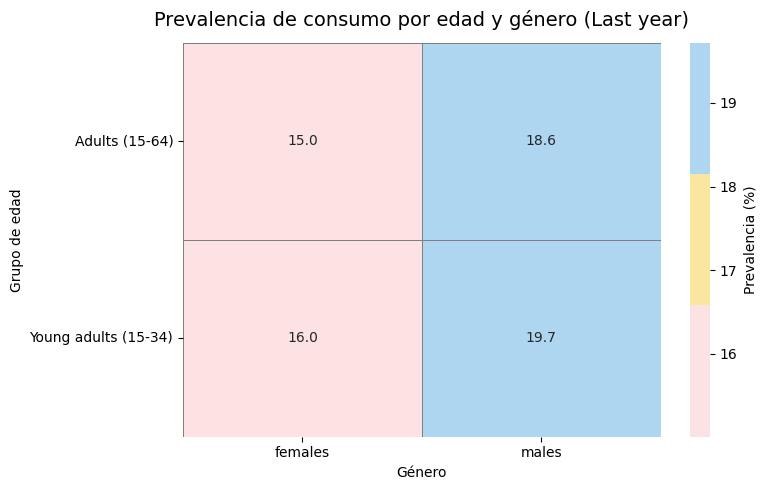

In [333]:

pivot_heat = df_mv_long.pivot_table(
    values="prevalence",
    index="age",
    columns="gender",
    aggfunc="mean"
)

plt.figure(figsize=(8,5))


sns.heatmap(
    pivot_heat,
    annot=True,
    fmt=".1f",
    cmap=["#FDE2E4", "#F9E79F", "#AED6F1"],  # Rosa, amarillo, azul clarito pastel
    cbar_kws={"label": "Prevalencia (%)"},
    linewidths=0.5,
    linecolor="gray"
)

plt.title("Prevalencia de consumo por edad y género (Last year)", fontsize=14, pad=12)
plt.ylabel("Grupo de edad")
plt.xlabel("Género")
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

La gráfica muestra la prevalencia de consumo de drogas segmentada por género y por grupo de edad y refleja que en general los hombres presentan una prevalencia ligeramente superior a la de las mujeres en todos los grupos de edad.

La diferencia entre jóvenes adultos y adultos es mínima, indicando que la edad por sí sola no tiene un efecto relevante sobre la prevalencia del consumo. Además, la interacción entre edad y género no resulta significativa

Paralelamente, se ha realizado análisis multivariante para estudiar si existen diferencias en el consumo de drogas entre hombres y mujeres según la edad y el tipo de sustancia.

In [335]:
df_mv = df_drugs[df_drugs["recall_period"]=="Last year"].copy()


df_mv = df_mv.dropna(subset=["males_(%)","females_(%)"])


# MANOVA

formula = 'Q("males_(%)") + Q("females_(%)") ~ C(age) + C(substance) + C(age):C(substance)'

manova = MANOVA.from_formula(formula, data=df_mv)
print("===== RESULTADOS MANOVA =====")
print(manova.mv_test())


df_mv["gender_gap"] = df_mv["males_(%)"] - df_mv["females_(%)"]

# ANOVA de la brecha según edad y sustancia

grupos_edad = [df_mv[df_mv["age"]==edad]["gender_gap"] for edad in df_mv["age"].unique()]
f_val, p_val = f_oneway(*grupos_edad)
print("\nANOVA de brecha por edad")
print("F:", f_val)
print("p:", p_val)


grupos_sustancia = [df_mv[df_mv["substance"]==s]["gender_gap"] for s in df_mv["substance"].unique()]
f_val2, p_val2 = f_oneway(*grupos_sustancia)
print("\nANOVA de brecha por sustancia")
print("F:", f_val2)
print("p:", p_val2)


# Post-hoc

print("\nPost-hoc: brecha por sustancia y edad")
for sust, age in itertools.product(df_mv["substance"].unique(), df_mv["age"].unique()):
    grupo = df_mv[(df_mv["substance"]==sust) & (df_mv["age"]==age)]
    if grupo.shape[0] > 1:  # necesitamos al menos 2 observaciones
        f_post, p_post = f_oneway(grupo["males_(%)"], grupo["females_(%)"])
        print(f"Sustancia: {sust}, Edad: {age}, F: {f_post:.2f}, p: {p_post:.4f}")


===== RESULTADOS MANOVA =====
                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept         Value  Num DF  Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda  0.0833 2.0000 338.0000 1859.2742 0.0000
         Pillai's trace  0.9167 2.0000 338.0000 1859.2742 0.0000
 Hotelling-Lawley trace 11.0016 2.0000 338.0000 1859.2742 0.0000
    Roy's greatest root 11.0016 2.0000 338.0000 1859.2742 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
            C(age)         Value  Num DF  Den DF  F Value Pr > F
----------------------------------------------------------------
             Wilks' lambda 0.9902 2.0000 338.0000  1.6690 0.1900
            Pil

En este análisis se ha estudiado el consumo de drogas diferenciando por género, edad y tipo de sustancia utilizando un enfoque multivariante mediante MANOVA. 

Los resultados indican la existencia de diferencias generales en los niveles de consumo de estupefacientes. Cabe señalar que la edad por sí sola no tiene un efecto significativo sobre los porcentajes de consumo de hombres y mujeres (Wilks' lambda cercano a 1 y p mayor a 0.05).

Por el contrario, la sustancia presenta un efecto muy significativo con p menor a 0.001, mostrando que el tipo de estupefaciente influye de manera significativa en los niveles de consumo tanto en hombres como en mujeres. 

En el análisis univariante de la brecha de género (diferencia entre el porcentaje de consumo masculino y femenino), informa que la sustancia sí muestra diferencias significativas con p extremadamente bajo (6.7e-53) lo que indica que la magnitud de la brecha entre hombres y mujeres depende claramente del tipo de droga, pero no de la edad (p valor superior al 5%)

Los análisis post-hoc detallan estas diferencias específicas mostrando que sustancias como Cannabis, Cocaína, Amphetaminas, Éxtasis, LSD, Alcohol y Tabaco tienen diferencias significativas en la brecha de género en adultos y jóvenes (F-values que oscilan entre 3.3 y 25.9 y p-values menores a 0.05). No obstante,  en el caso del Alcohol en jóvenes  (p = 0.0746) se aprecia que la brecha de género no es uniforme y depende de la combinación de sustancia y grupo de edad


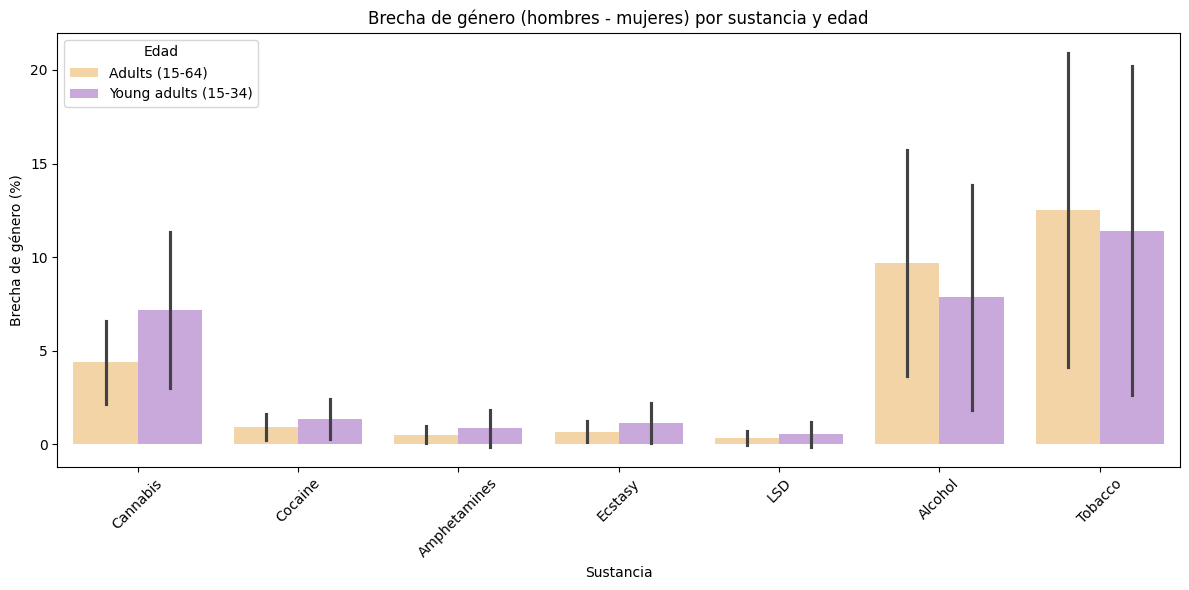

In [338]:
plt.figure(figsize=(12,6))

sns.barplot(
    data=df_mv,
    x="substance",
    y="gender_gap",
    hue="age",
    errorbar="sd",
    palette=["#FFD699", "#CBA0E3"]  # Amarillo pastel y lila pastel
)

plt.title("Brecha de género (hombres - mujeres) por sustancia y edad")
plt.ylabel("Brecha de género (%)")
plt.xlabel("Sustancia")
plt.xticks(rotation=45)
plt.legend(title="Edad")
plt.tight_layout()
plt.show()

La gráfica refleja claramente que tanto la sustancia como la edad influyen en la magnitud de la brecha de género, corroborando los hallazgos de los ANOVA y MANOVA que muestran diferencias significativas según la sustancia y menores efectos según la edad.

**Gráfica: brecha de género**

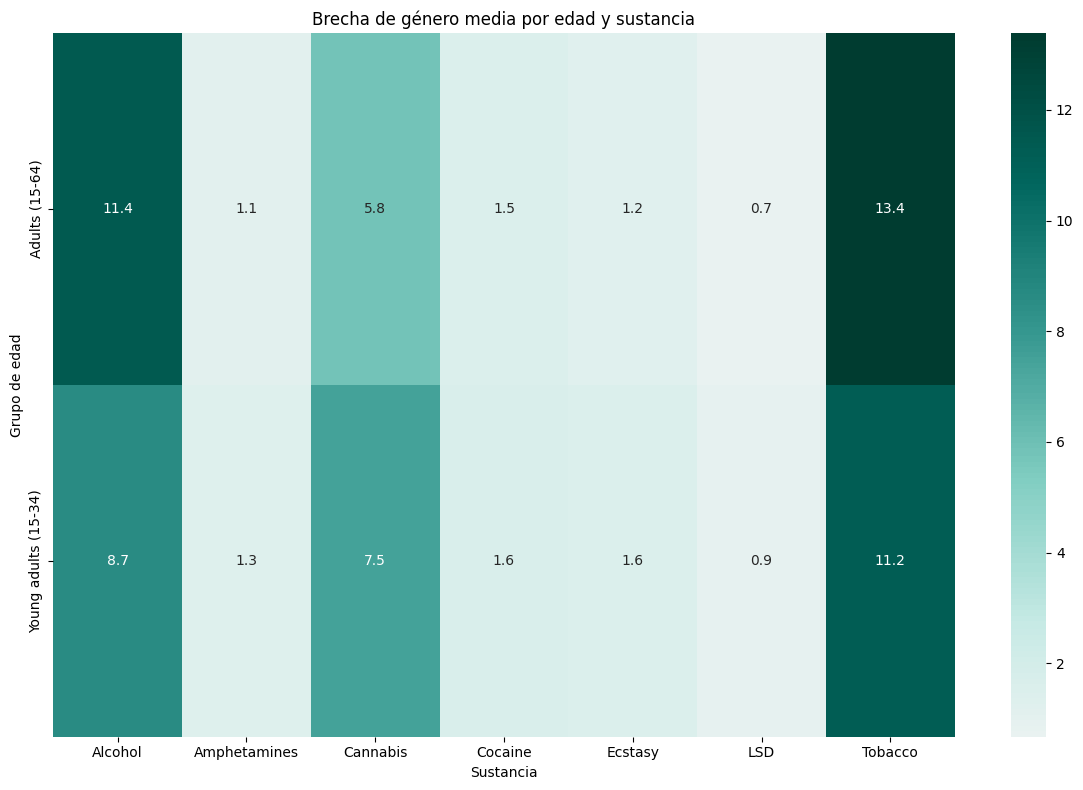

In [339]:
pivot_gap2 = df_drugs.pivot_table(
    values="gender_gap",
    index="age",
    columns="substance",
    aggfunc="mean"
)

plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_gap2,
    cmap="BrBG",
    center=0,
    annot=True,
    fmt=".1f"
)
plt.title("Brecha de género media por edad y sustancia")
plt.xlabel("Sustancia")
plt.ylabel("Grupo de edad")
plt.tight_layout()
plt.show()

La heatmap muestra que en todas las sustancias los hombres tienden a consumir más que las mujeres, reflejado por los valores positivos de gender_gap. Las brechas más grandes se observan en Alcohol y tabaco, especialmente en adultos, mientras que en drogas como Cannabis, Cocaína o LSD la diferencia es mayor en jóvenes adultos. Esta visualización confirma y complementa los resultados de los análisis estadísticos previos, mostrando claramente cómo la edad y la sustancia modulan la brecha de género.

**Conclusión**

En este análisis multivariante se ha analizado la influencia de la edad y del tipo de sustancia sobre el consumo de drogas en hombres y mujeres y sobre la brecha de género. Los resultados muestran que el factor edad por sí solo no genera diferencias significativas en el consumo porque los grupos de jóvenes adultos y adultos presentan patrones globalmente similares. No obstante, el tipo de sustancia tiene un efecto significativo, indicando que determinadas sustancias son consumidas de manera muy diferente entre hombres y mujeres. 

El análisis de la brecha de género confirma que existe una diferencia consistente entre hombres y mujeres, siendo los hombres los que presentan mayores niveles de consumo en casi todas las sustancias. Esta brecha varía según la droga y en menor medida según la edad, siendo más pronunciada en Alcohol y tabaco.

En conjunto, estos resultados indican que el género y el tipo de sustancia son los principales determinantes de las diferencias en consumo, mientras que la edad tiene un efecto secundario y limitado. 

## 1.4 CONCLUSIÓN HIPÓTESIS  1

En la Hipótesis 1 *"H1. Los hombres consumen más estupefacientes que las mujeres en todos los grupos de edad"* se ha estudiado el consumo de diversas sustancias considerando las variables sustancia, edad y género. 

A nivel **univariante** se apreció que el consumo medio difiere entre sustancias, siendo el Alcohol y el tabaco las de mayor prevalencia, mientras que drogas como LSD o éxtasis presentan valores mucho más bajos. Asimismo, el consumo de hombres es sistemáticamente más alto que el de mujeres y se aprecia una brecha de género consistente. Además, las diferencias por edad han mostrado que los jóvenes adultos presentan un consumo ligeramente mayor en algunas sustancias como Cannabis y Cocaína, aunque en otras la diferencia es mínima.

En el análisis **bivariante**, se ha confirmado que tanto la sustancia como el género influyen significativamente en la prevalencia del consumo: los hombres consumen más que las mujeres en todas las sustancias y que ciertos grupos de edad presentan mayor consumo en drogas concretas. No obstante, la edad por sí sola no tiene un efecto global significativo, aunque se han identificado diferencias específicas según la sustancia.

En el análisis **multivariante**, el MANOVA ha informado que la sustancia tiene un efecto muy significativo sobre el consumo de hombres y mujeres simultáneamente, mientras que la edad por sí sola no tiene un efecto global significativo. La interacción de edad × sustancia ha most5rado efectos limitados, significativos solo en ciertos casos, confirmando que las diferencias por edad dependen de la droga analizada. La brecha de género también tiene diferencias significativas entre sustancias, siendo más marcada en Alcohol y Tabaco.

En conjunto, estos resultados permiten concluir que la Hipótesis 1 queda parcialmente aceptada: los hombres sí que consumen más estupefacientes que las mujeres pero no en todas las edades, esto es, las diferencias de edad, en generla, no son significaivas y dependen del tipo de sustancia. 


# **HIPÓTESIS 2**

>*H2. Existen diferencias en la prevalencia del consumo de estupefacientes entre países europeos*

Igual que anteriormente, mostramos el dataframe:

In [45]:
df_drugs

,country,survey_year,prevalence_(%),substance,recall_period,age,sample_size,males_(%),females_(%),gender_gap
0,Austria,2020,22.7,Cannabis,Lifetime,Adults (15-64),4650.0,24.8,20.6,4.2
1,Austria,2020,27.2,Cannabis,Lifetime,Young adults (15-34),1712.0,26.8,27.6,-0.8
2,Austria,2020,6.3,Cannabis,Last year,Adults (15-64),4650.0,6.8,5.8,1.0
3,Austria,2020,11.1,Cannabis,Last year,Young adults (15-34),1712.0,10.7,11.4,-0.7
4,Austria,2020,3.6,Cannabis,Last month,Adults (15-64),4650.0,4.0,3.1,0.9
...,...,...,...,...,...,...,...,...,...,...
1038,Türkiye,2017,47.0,Tobacco,Lifetime,Young adults (15-34),NaN,61.9,33.2,28.7
1039,Türkiye,2017,33.4,Tobacco,Last year,Adults (15-64),NaN,45.0,22.5,22.5
1040,Türkiye,2017,33.2,Tobacco,Last year,Young adults (15-34),NaN,45.4,20.6,24.8
1041,Türkiye,2017,31.5,Tobacco,Last month,Adults (15-64),NaN,42.8,21.0,21.8


## 2.1 ANÁLISIS UNIVARIANTE

Para la evaluación de la Hipótesis 2, la variable principal de interés es **country**, puesto que el objetivo es analizar diferencias en la prevalencia de consumo de estupefacientes entre países europeos. Adicionalmente, se han considerado variables como recall_period.

### Variables **Categóricas**

In [202]:
df_drugs.columns = df_drugs.columns.str.lower()

In [203]:
categorical_cols = [
    "country",    
    "substance",
    "recall_period",
    "age"
]

In [207]:
df_drugs["country"].describe()

count        1043
unique         29
top       Austria
freq           42
Name: country, dtype: object

Al analizar los datos descriptivos de **country**, se observa:

* El conjunto de datos contiene 1.043 observaciones.
* Hay 29 países diferentes representados, proporcionando, así una cobertura amplia de Europa.
* El país con mayor frecuencia de observaciones es Austria, con 42 registros, hecho que reflejaría más estudios o encuestas desarrolladas en el país 

In [208]:
df_drugs["recall_period"].describe()

count          1043
unique            3
top       Last year
freq            367
Name: recall_period, dtype: object

Por su parte, la variable **recall_period** muestra:

* Existen 3 categorías distintas: “Last month”, “Last year” y “Lifetime”.
* La categoría más frecuente es “Last year” (367 observaciones) e indica que la mayoría de los registros se refieren al consumo durante el último año.

En términos generales, estos datos permiten contextualizar el análisis, asegurando que las comparaciones entre países se realizan sobre una base adecuada de observaciones y teniendo en cuenta el periodo de referencia del consumo reportado.

Por otro lado, para la evaluación de esta hipótesis, se han estudiado las principales variables categóricas: country, substance, recall_period y age. Esto permitirá entender la composición de los datos y contextualizar la comparación de la prevalencia de consumo entre países.

In [209]:
for col in categorical_cols:
    print(f"\n--- {col}---")
    display(df_drugs[col].value_counts(dropna=False))


--- country---


country
Austria        42
Bulgaria       42
Croatia        42
Cyprus         42
Germany        42
Portugal       42
Romania        42
Italy          42
Slovakia       42
Ireland        42
Latvia         41
Czechia        40
Lithuania      40
Hungary        38
Finland        38
Türkiye        38
Poland         36
Estonia        36
Spain          36
Luxembourg     36
Netherlands    34
Slovenia       34
Greece         32
Denmark        30
France         30
Norway         30
Sweden         22
Belgium        20
Malta          12
Name: count, dtype: int64


--- substance---


substance
Cannabis        171
Cocaine         159
Ecstasy         159
Amphetamines    149
LSD             148
Alcohol         132
Tobacco         125
Name: count, dtype: int64


--- recall_period---


recall_period
Last year     367
Lifetime      348
Last month    328
Name: count, dtype: int64


--- age---


age
Adults (15-64)          528
Young adults (15-34)    515
Name: count, dtype: int64

**1. Países (country)**

El dataset incluye 29 países con un total de 1.043 registros. La mayoría de los estados tienen entre 30 y 42 observaciones, siendo Austria, Bulgaria, Croacia y Chipre, entre otros, los más representados (42 registros cada uno). En el extremo inferior, países como Suecia y Bélgica tienen menos registros, y Malta es el país con menos datos (12 registros).

**2. Sustancias (substance)**

En el estudio se incluyen 7 sustancias diferentes, con el Cannabis como la más frecuente (171 registros), seguido de la Cocaína y el Éxtasis (159 cada uno). Las sustancias con menor representación son el Alcohol (132) y el Tabaco (125), mientras que el LSD y las Anfetaminas tienen conteos intermedios. Esto indica que las encuestas europeas han prestado mayor atención a Cannabis, probablemente porque es la droga más consumida y socialmente relevante en Europa. Las sustancias como LSD, Anfetaminas, Alcohol y Tabaco presentan menos registros, lo que podría reflejar una menor frecuencia de consumo reportada.

**3. Periodo de recuerdo (recall_period)**

El periodo de recuerdo más común es “Last year” (367 registros), seguido de “Lifetime” (348) y “Last month” (328). Esto sugiere que la mayoría de los datos se centran en el consumo reciente (último año), pero también se dispone de información sobre consumo histórico y mensual.

**4. Grupo de edad (age)**

Los registros se dividen prácticamente a partes iguales entre “Adults (15-64)” (528 registros) y “Young adults (15-34)” (515 registros)

A continuación, se muestran las gráficas de cada una de las variables ya comentadas:

*Substance*

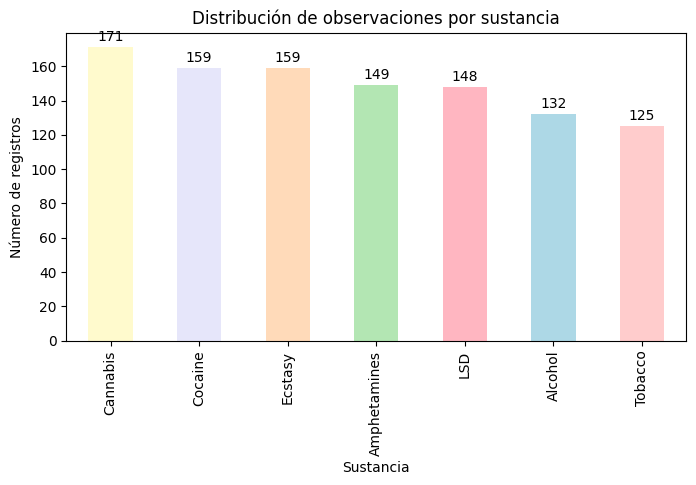

In [211]:
colors = ["#FFFACD", "#E6E6FA", "#FFDAB9", "#B3E6B3", "#FFB6C1", "#ADD8E6", "#FFCCCC"]

counts = df_drugs["substance"].value_counts()

plt.figure(figsize=(8,4))
bars = counts.plot(kind="bar", color=colors)

plt.title("Distribución de observaciones por sustancia")
plt.ylabel("Número de registros")
plt.xlabel("Sustancia")


for i, val in enumerate(counts):
    plt.text(i, val + 2, str(val), ha='center', va='bottom')

plt.show()

*Country*

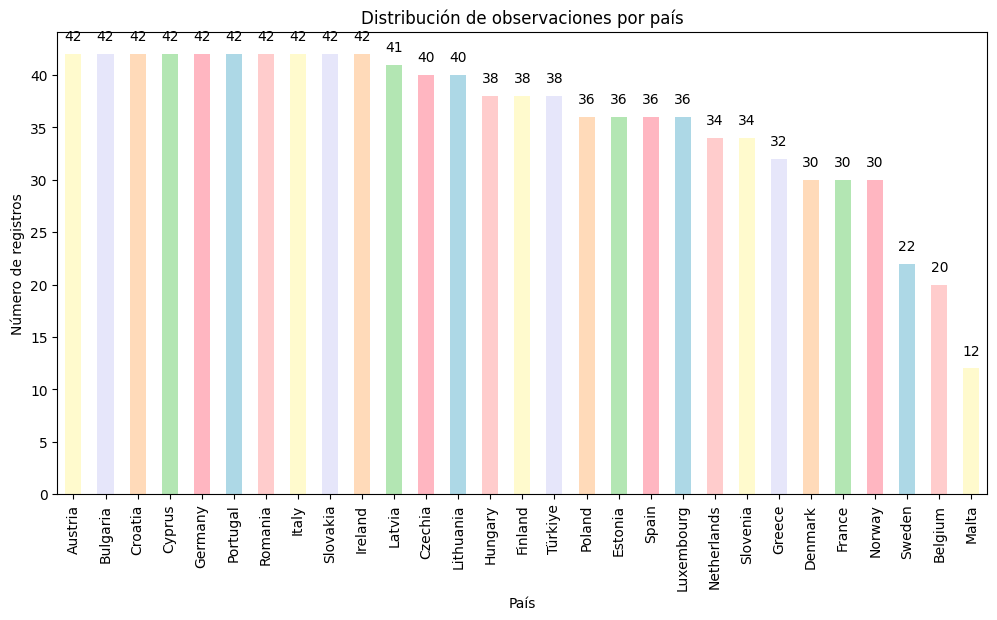

In [218]:
counts = df_drugs["country"].value_counts()
colors = ["#FFFACD", "#E6E6FA", "#FFDAB9", "#B3E6B3", "#FFB6C1", "#ADD8E6", "#FFCCCC"] 

plt.figure(figsize=(12,6))
bars = counts.plot(kind="bar", color=colors * (len(counts)//len(colors)+1)) 

plt.title("Distribución de observaciones por país")
plt.ylabel("Número de registros")
plt.xlabel("País")

for i, val in enumerate(counts):
    plt.text(i, val + 1, str(val), ha='center', va='bottom')

plt.show()

*Recall_period*

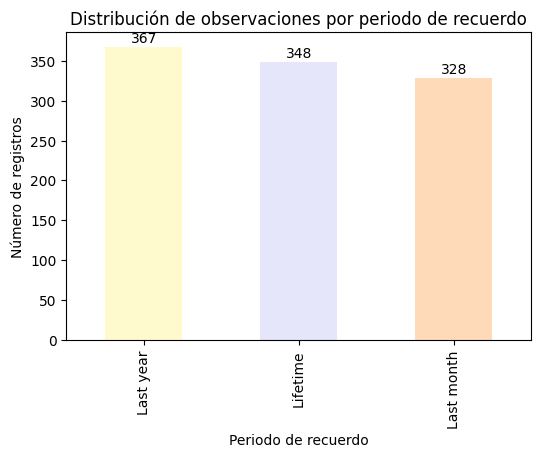

In [216]:
counts = df_drugs["recall_period"].value_counts()

plt.figure(figsize=(6,4))
bars = counts.plot(kind="bar", color=colors[:len(counts)])

plt.title("Distribución de observaciones por periodo de recuerdo")
plt.ylabel("Número de registros")
plt.xlabel("Periodo de recuerdo")

for i, val in enumerate(counts):
    plt.text(i, val + 2, str(val), ha='center', va='bottom')

plt.show()

*Age*

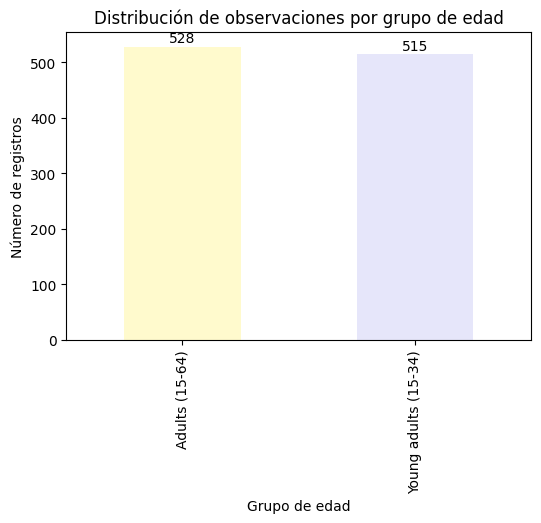

In [217]:
counts = df_drugs["age"].value_counts()

plt.figure(figsize=(6,4))
bars = counts.plot(kind="bar", color=colors[:len(counts)])

plt.title("Distribución de observaciones por grupo de edad")
plt.ylabel("Número de registros")
plt.xlabel("Grupo de edad")

for i, val in enumerate(counts):
    plt.text(i, val + 2, str(val), ha='center', va='bottom')

plt.show()

## 2.2 ANÁLISIS BIVARIANTE

Para profundizar en la Hipótesis 2, se ha realizado un análisis bivariante, el cual nos ha permitido explorar relaciones entre 2 variables a la vez, así como apreciar cómo varía el consumo de estupefacientes en función del sexo, la sustancia y el país. El análisis se ha organizado en dos secciones, según el tipo de variables involucradas:

* Categórica - categórica
* Categórica - numérica

Cabe señalar que no se ha realizado ningún análisis de variables numéricas - numéricas porque, en este caso, no es de interés. El motivo viene dado porque el eje central de este estudio (de la presente hipótesis) es la variable país, la cual es categórica.

### CATEGÓRICA - CATEGÓRICA

En esta sección se estudian las relaciones entre variables categóricas, concretamente entre **substance** y **country**, para explorar cómo se distribuye el consumo por país según el tipo de sustancia.

In [273]:
df_drugs.groupby("substance")["country"].value_counts(normalize=True)

substance  country    
Alcohol    Austria        0.045455
           Bulgaria       0.045455
           Croatia        0.045455
           Cyprus         0.045455
           Finland        0.045455
                            ...   
Tobacco    Malta          0.024000
           Finland        0.016000
           Netherlands    0.016000
           Norway         0.016000
           Sweden         0.016000
Name: proportion, Length: 195, dtype: float64

Para analizar la relación entre el país y el tipo de sustancia, se ha calculado la proporción de registros de cada sustancia por estado. Los resultados señalan que no todos los países tienen la misma distribución de sustancias. Por ejemplo, Alcohol, Cannabis y Cocaína aparecen en la mayoría de los países, mientras que estupefacientes como LSD muestran proporciones más bajas en ciertos países, e incluso ausencia en algunos casos.

Estos hallazgos indican que el patrón de consumo no sería uniforme en Europa, sino que depende tanto del país como de la sustancia. Algunos países presentan una mayor proporción de registros para ciertas sustancias. Por ejemplo, países como Austria o Croacia tienen una distribución relativamente equilibrada entre diversas sustancias, mientras que otros estados presentan concentraciones más específicas, como Malta en Alcohol y Cannabis.

Para estudiar si existen diferencias en la prevalencia de consumo de drogas entre países europeos, se ha examinado la distribución de registros por país y sustancia mediante una tabla de contingencia y sus proporciones relativas.

In [249]:
tabla_contingencia2 = pd.crosstab(df_drugs['country'], df_drugs['substance'])
tabla_contingencia2

substance,Alcohol,Amphetamines,Cannabis,Cocaine,Ecstasy,LSD,Tobacco
country,,,,,,,
Austria,6,6,6,6,6,6,6
Belgium,2,2,6,2,2,2,4
Bulgaria,6,6,6,6,6,6,6
Croatia,6,6,6,6,6,6,6
Cyprus,6,6,6,6,6,6,6
Czechia,4,6,6,6,6,6,6
Denmark,0,6,6,6,6,6,0
Estonia,2,6,6,6,6,6,4
Finland,6,6,6,6,6,6,2


In [251]:
tabla_prop = tabla_contingencia.div(tabla_contingencia.sum(axis=1), axis=0)
tabla_prop

substance,Alcohol,Amphetamines,Cannabis,Cocaine,Ecstasy,LSD,Tobacco
country,,,,,,,
Austria,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
Belgium,0.100000,0.100000,0.300000,0.100000,0.100000,0.100000,0.200000
Bulgaria,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
Croatia,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
Cyprus,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
Czechia,0.100000,0.150000,0.150000,0.150000,0.150000,0.150000,0.150000
Denmark,0.000000,0.200000,0.200000,0.200000,0.200000,0.200000,0.000000
Estonia,0.055556,0.166667,0.166667,0.166667,0.166667,0.166667,0.111111
Finland,0.157895,0.157895,0.157895,0.157895,0.157895,0.157895,0.052632


Los resultados de este análisis destacan que existen sustancias ampliamente consumidas (como Cannabis, Cocaína y Éxtasis) y que presentan un número relativamente uniforme de registros en la mayoría de países, incluyendo Austria, Bulgaria, Italia y Portugal. 

Contrariamente, otras sustancias como Alcohol, Tabaco y LSD presentan patrones mucho más irregulares. Por ejemplo, Malta concentra un porcentaje elevado de registros en Alcohol y Tabaco (≈25% cada uno) y no tiene registros de LSD. Dinamarca no registra Alcohol ni Tabaco, mientras que España no tiene de registros de LSD. 

Al normalizar los datos por país, se observa que algunos países, como Austria, Portugal e Italia, mantienen proporciones similares entre todas las sustancias, mostrando un patrón equilibrado. No obstante, otros estados como Suecia o Dinamarca presentan proporciones muy heterogéneas, reflejando, así, diferencias en la prevalencia relativa de consumo.


### CATEGORICA - NUMÉRICA

Respecto el análisis de variables categóricas (país) y numérica, ha sido necesario estudiar las diferencias del consumo de estupefacientes por país. Para ello, se ha examinado diversas variables.
En primer lugar, se ha examinado la variable numérica females_(%), la cual representa el porcentaje de mujeres consumidoras de estupefacientes, en función de la variable categórica country. Se han calculado estadísticas descriptivas por país y se evaluó la distribución relativa mediante gráficas.

*País y consumo de mujeres*

In [253]:
df_drugs.groupby("country")["females_(%)"].describe()

,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
Austria,42.0,20.723810,30.216219,0.0,0.725,4.10,28.050,94.3
Belgium,20.0,17.175000,24.377381,0.0,0.500,3.85,24.725,79.4
Bulgaria,42.0,18.304762,26.690338,0.0,0.400,1.75,47.175,76.4
Croatia,42.0,20.428571,29.227654,0.0,0.800,2.80,40.650,92.1
Cyprus,42.0,15.030952,24.598369,0.0,0.100,0.50,27.175,79.2
Czechia,40.0,16.997500,25.073937,0.0,0.850,2.85,29.150,81.4
Denmark,30.0,4.276667,8.770038,0.1,0.200,1.00,4.225,38.2
Estonia,36.0,12.188889,21.853889,0.0,0.500,2.50,9.475,83.4
Finland,38.0,17.700000,29.558700,0.0,0.600,2.10,18.700,92.5


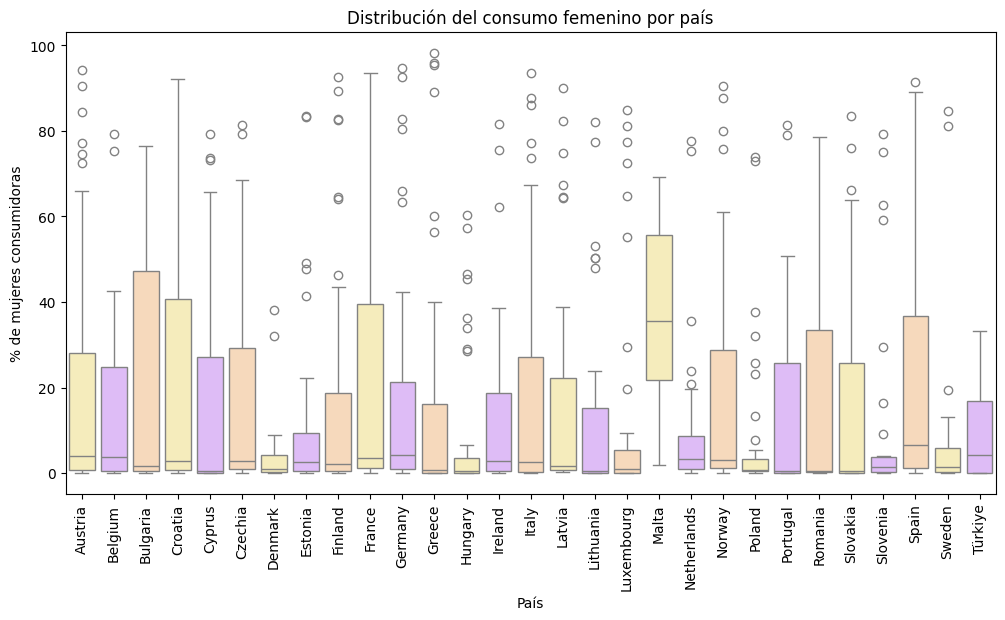

In [289]:
paleta = sns.color_palette(["#fff2b2","#e0b3ff","#ffd9b3"], n_colors=df_drugs['country'].nunique())

plt.figure(figsize=(12,6))
sns.boxplot(
    x='country', 
    y='females_(%)', 
    hue='country',
    data=df_drugs, 
    palette=paleta,
    dodge=False 
)
plt.xticks(rotation=90)
plt.title('Distribución del consumo femenino por país')
plt.ylabel('% de mujeres consumidoras')
plt.xlabel('País')
plt.legend([],[], frameon=False)
plt.show()

El análisis ha mostrado diferencias significativas entre países europeos. 

Concretamente, Malta tiene el promedio más alto de consumo femenino, con aproximadamente un 37%, mientras que Francia y España se sitúan en torno al 23%, y Austria en torno al 21%. Por su parte, Polonia, Hungría y Turquñia muestran los valores más bajos (alrededor del 9–10%). 

Además, se aprecia una variabilidad elevada en muchos países: en Italia, Croacia y Austria la desviación estándar llega a tener valores cercanos al 30%, con registros que van desde prácticamente 0% hasta más del 90%. Esto indicaría que, aunque puedan tener un promedio nacional moderado, podrían existir subgrupos dentro de cada estado con niveles de consumo femeninos distintos.

En conjunto, estos resultados sugieren que sí existen diferencias en la prevalencia femenina del consumo de drogas entre países europeos.

*País y consumo de hombres*

In [256]:
df_drugs.groupby("country")["males_(%)"].describe()

,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
Austria,42.0,21.716667,30.428508,0.1,1.200,6.10,30.525,95.4
Belgium,20.0,22.825000,26.300748,0.0,2.125,11.30,33.750,85.0
Bulgaria,42.0,20.861905,31.062604,0.0,0.400,1.70,50.775,88.5
Croatia,42.0,25.240476,31.120459,0.1,2.100,7.55,46.100,94.1
Cyprus,42.0,22.580952,31.904126,0.1,0.425,2.50,50.550,87.8
Czechia,40.0,23.122500,28.698034,0.1,1.300,6.40,40.850,88.8
Denmark,30.0,6.950000,11.362757,0.0,0.625,2.90,8.200,46.9
Estonia,36.0,16.452778,24.544496,0.0,1.450,5.30,16.475,88.4
Finland,38.0,21.005263,30.204939,0.3,1.525,5.55,27.375,92.2


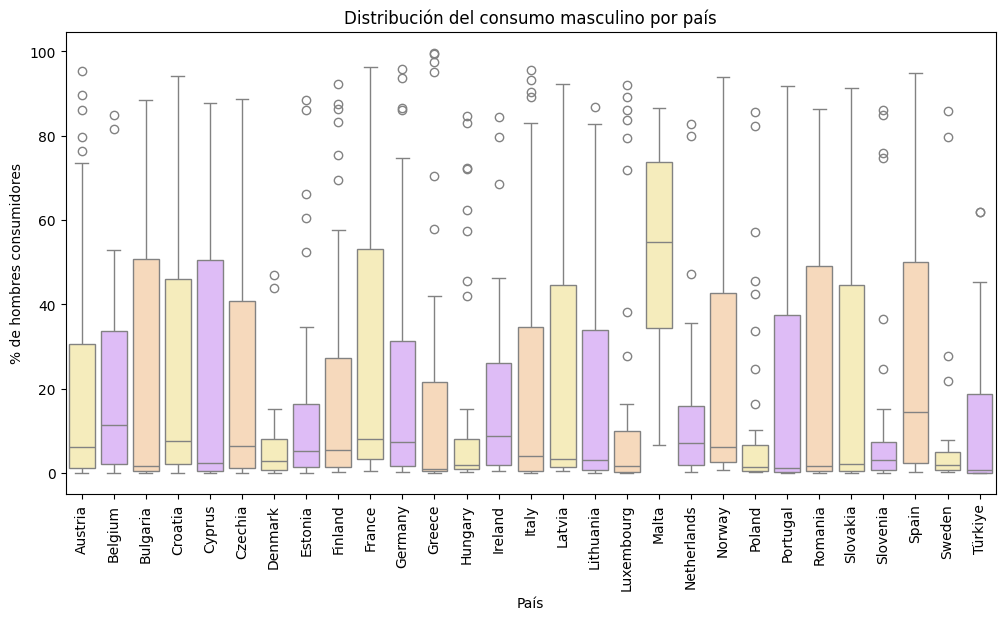

In [278]:
paleta = sns.color_palette(["#fff2b2","#e0b3ff","#ffd9b3"], n_colors=df_drugs['country'].nunique())

plt.figure(figsize=(12,6))
sns.boxplot(
    x='country',
    y='males_(%)',
    hue='country', 
    data=df_drugs,
    palette=paleta,
    dodge=False 
)
plt.xticks(rotation=90)
plt.title('Distribución del consumo masculino por país')
plt.ylabel('% de hombres consumidores')
plt.xlabel('País')
plt.legend([],[], frameon=False)
plt.show()

El análisis del consumo masculino revelaría diferencias estadísticamente significativas entre países europeos. Concretamente, Malta destaca con el promedio más alto de consumo masculino (aproximadamente 52%), por encima del resto de países. Francia y Esopaña también tienen promedios relativamente altos (alrededor del 29–28%), mientras que países como Países Bajos o Polonia muestran los valores más bajos (alrededor del 12–14%).

Igual que en el caso femenino, muchos estados presentan alta variabilidad. Italia, Croacia y Austria muestran desviaciones estándar cercanas a 30%, con valores mínimos muy bajos y máximos que superan el 90%. Esto indicaría que, a pesar de que el promedio nacional puede ser moderado, existen subgrupos con niveles de consumo muy diferentes dentro del mismo país. Otros países, como Malta, mostrarían menor dispersión relativa, reflejando datos más concentrados alrededor de sus promedios.

En conjunto, estos resultados indican que existen diferencias claras en la prevalencia masculina de consumo entre países europeos

*País y prevalencia de consumo general*

In [260]:
df_drugs.groupby("country")["prevalence_(%)"].describe()

,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
Austria,42.0,21.233333,30.311808,0.0,1.000,5.15,29.225,94.9
Belgium,20.0,19.955000,25.236116,0.0,1.350,7.55,28.975,82.1
Bulgaria,42.0,19.542857,28.781499,0.0,0.400,2.05,49.250,82.2
Croatia,42.0,22.857143,30.133428,0.0,1.475,5.20,43.375,92.8
Cyprus,42.0,18.745238,28.023233,0.1,0.300,1.50,38.500,83.5
Czechia,40.0,20.100000,26.749809,0.1,1.200,4.95,35.100,84.0
Denmark,30.0,5.590000,10.043607,0.0,0.400,1.90,6.200,42.6
Estonia,36.0,13.919444,22.874488,0.1,0.875,3.50,12.325,85.4
Finland,38.0,19.350000,29.804224,0.2,1.025,3.90,23.075,92.3


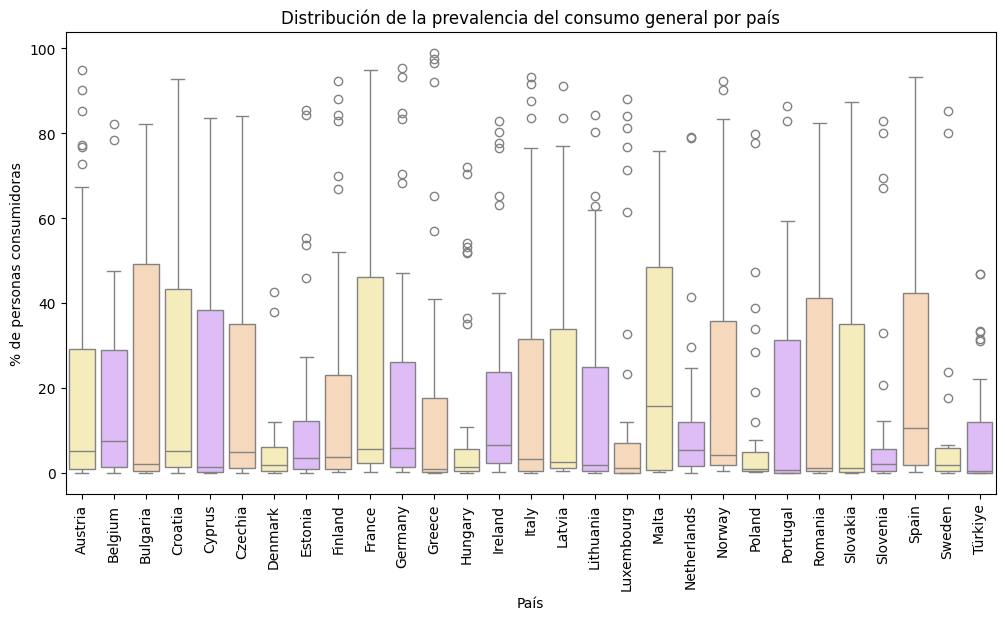

In [279]:
paleta = sns.color_palette(["#fff2b2","#e0b3ff","#ffd9b3"], n_colors=df_drugs['country'].nunique())

plt.figure(figsize=(12,6))
sns.boxplot(
    x='country',
    y='prevalence_(%)',
    hue='country',
    data=df_drugs,
    palette=paleta,
    dodge=False 
)
plt.xticks(rotation=90)
plt.title('Distribución de la prevalencia del consumo general por país')
plt.ylabel('% de personas consumidoras')
plt.xlabel('País')
plt.legend([],[], frameon=False)
plt.show()

El presente análisis muestra diferencias significativas entre países europeos respecto la prevalencia del consumo de estupefacientes.
Al observar la prevalencia general (prevalence_(%)), los estados con mayor consumo total incluyen Malta, España y Francia, (promedios de aproximadamente 26–27%), mientras que Polonia y Turquía registran los valores más bajos (entre 8 y 10%). En la mayoría de estados se observa una variabilidad interna elevada, con desviaciones estándar que en muchos casos superan el 25–30%, y con rangos que van desde prácticamente 0% hasta más del 90%. Esto indica que, aunque los promedios nacionales pueden ser moderados, existen subgrupos dentro de cada país con niveles de consumo muy distintos.

Estos resultados muestran que existen diferencias claras en la prevalencia del consumo de drogas entre países europeos, tanto en mujeres como en hombres (y en términos generales) y que la variabilidad interna es considerable. Países como Malta presentan un consumo especialmente elevado, mientras que Polonia y Turquía registran niveles bajos y más homogéneos. La heterogeneidad interna y las diferencias entre países sugieren que las estrategias de prevención e intervención deberían adaptarse a las características específicas de cada país y, potencialmente, a subgrupos poblacionales diferenciados, considerando también las diferencias por género cuando se disponga de esos datos.

**Análisis ANOVA**

*Prevalencia del consumo y países*

In [280]:
grupos2 = df_drugs['country'].dropna().unique()

prevalencia_por_grupo2 = [
    df_drugs[df_drugs['country'] == pais]['prevalence_(%)'].dropna()
    for pais in grupos2
    if df_drugs[df_drugs['country'] == pais]['prevalence_(%)'].dropna().shape[0] > 1
]


if len(prevalencia_por_grupo2) < 2:
    print("No hay suficientes grupos para hacer ANOVA")
else:
    # ANOVA
    f_val, p_val = stats.f_oneway(*prevalencia_por_grupo2)
    print("Valor F:", f_val)
    print("Valor p:", p_val)

Valor F: 1.2024510117328868
Valor p: 0.21628427104906703


Para anallizar si existen diferencias significativas en la prevalencia del consumo de estupefacientes entre países europeos, se ha realizado un análisis de varianza (ANOVA) considerando la variable prevalence_(%) agrupada por país. Esto permite comparar las medias de varios grupos y determinar si al menos un país difiere significativamente del resto en términos de consumo.

* Los resultados del ANOVA mostraron un valor F de 1.20 y un valor p de 0.216.

Esto indica que no se pueden considerar estadísticamente significativas las diferencias en la prevalencia media entre países (porque el valor p es mayor que 0.05). Esto significa que, aunque en los análisis descriptivos observamos que algunos países tienen promedios más altos (como Malta, España y Francia) y otros más bajos (como Truquía y Polonia), la variabilidad interna y el tamaño de las muestras hacen que estas diferencias no sean tan fuertes ccomo para concluir que existen diferencias reales a nivel poblacional.

Esto es, los resultados del ANOVA sugieren que, aunque hay diferencias visibles en los promedios de consumo entre países, estas podrían ser atribuibles al azar y no constituyen una evidencia significativa de que la prevalencia del consumo difiera entre países europeos. 

*Prevalencia del consumo de drogas entre países por sustancia en el último año*

In [281]:
df_country = df_drugs[df_drugs["recall_period"] == "Last year"]

df_country = (
    df_country.sort_values("survey_year")
    .groupby(["substance", "country"])
    .tail(1)
)

grupos_country = [
    df_country[df_country["country"] == country]["prevalence_(%)"].dropna()
    for country in df_country["country"].unique()
    if df_country[df_country["country"] == country]["prevalence_(%)"].dropna().shape[0] > 1
]

f_val, p_val = stats.f_oneway(*grupos_country)

print("ANOVA por país")
print("F:", f_val)
print("p:", p_val)

ANOVA por país
F: 0.13358608641505126
p: 0.9999999707722119


Para profundizar en la Hipótesis 2, se ha realizado un análisis ANOVA considerando solo los datos más recientes de cada país y sustancia, esto es, registros correspondientes al último año. Esto permite comparar la prevalencia del consumo entre países de manera más actualizada y centrada en cada tipo de droga.

* El ANOVA muestra un valor F de 0.13 y un valor p prácticamente igual a 1.

Estos resultados indicarían que no existen diferencias estadísticamente significativas en la prevalencia media de consumo entre países cuando se analiza cada sustancia considerando únicamente el último año. Entonces, aunque se observan determinadas tendencias visuales en los datos, los estados presentan un patrón parecido de prevalencia de consumo por sustancia en el último año, y cualquier variación aparente podría deberse al azar. Esto sugeriría que, desde la perspectiva de la prevalencia de consumo reciente por tipo de droga, las diferencias entre países europeos no son relevantes estadísticamente.

*Prevalencia del consumo de drogas entre países por sustancia*

In [282]:
grupos_country = [
    df_age[df_age["country"] == country]["prevalence_(%)"].dropna()
    for country in df_age["country"].unique()
    if df_age[df_age["country"] == country]["prevalence_(%)"].dropna().shape[0] > 1
]

f_val, p_val = stats.f_oneway(*grupos_country)

print("ANOVA por país")
print("F:", f_val)
print("p:", p_val)

ANOVA por país
F: 8.524205581288477
p: 0.005809841843812002


Por otro lado, es necesario analizar si la prevalencia del consumo de drogas difiere entre países europeos según cada tipo de sustancia. Para ello, se ha realizado un ANOVA considerando los datos agrupados por país. Esto permite comparar las medias de consumo entre varios grupos, así como determinar si al menos un país presenta diferencias significativas respecto al resto. Los resultados del ANOVA han mostrado:

* Valor F de 8.52 y un valor p de 0.006.

Esto indica que las diferencias observadas en la prevalencia del consumo entre países son significativas al nivel del 5%. Así, al analizar la prevalencia de consumo por tipo de sustancia, algunos estados tienen medias de consumo significativamente mayores o menores que otros. Esto confirmaría que la distribución del consumo no es homogénea en Europa y que hay factores asociados al país que podrían estar influyendo en dichas diferencias.

En otras palabras, aunque los análisis generales de prevalencia global mostraban variaciones que no eran estadísticamente significativas, cuando se desglosa por sustancia concreta, las diferencias entre países se vuelven relevantes y reflejan patrones consistentes de variabilidad en el consumo.

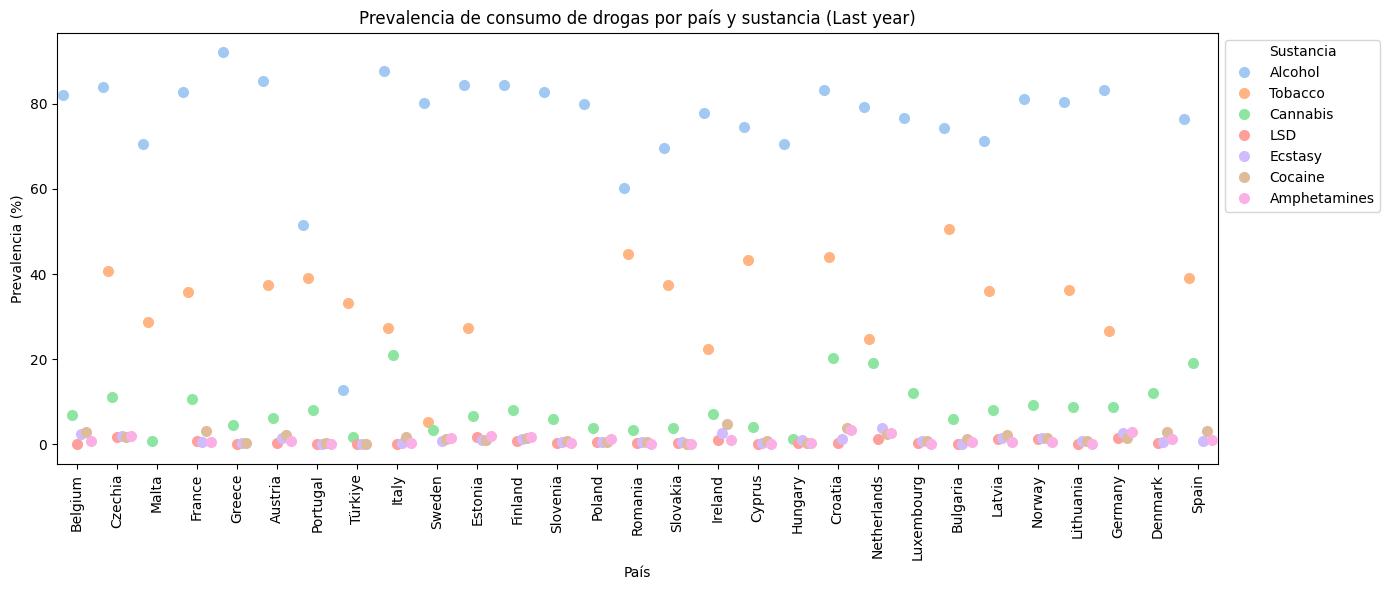

In [272]:
plt.figure(figsize=(14,6))
sns.stripplot(
    data=df_country,
    x="country",
    y="prevalence_(%)",
    hue="substance",
    dodge=True,
    palette="pastel",
    size=8
)
plt.title("Prevalencia de consumo de drogas por país y sustancia (Last year)")
plt.ylabel("Prevalencia (%)")
plt.xlabel("País")
plt.xticks(rotation=90)
plt.legend(title="Sustancia", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

Esta gráfica relativa a la prevalencia de consumo de drogas por país y sustancia permite visualizar de forma clara cómo varía el consumo entre los distintos estados europeos para cada tipo de droga durante el último año. Cada barra representa la prevalencia media de consumo de una sustancia concreta en un país, y los colores diferencian las distintas sustancias.

A simple vista, se aprecia que algunos estados tienen niveles de consumo destacadamente más altos para ciertas drogas, mientras que otros mantienen una prevalencia más baja. Por ejemplo, sustancias como el cannabis y el Alcohol tienden a mostrar valores más elevados en diversos países, mientras que drogas como LSD o extasis presentan prevalencias más bajas y más uniformes entre países.

Estas diferencias visuales confirman lo que indicaba el ANOVA por país y sustancia: existen variaciones significativas en la prevalencia entre países, aunque no todos los países presentan la misma magnitud de consumo para cada droga. La gráfica también ha permitido identificar ciertos patrones: algunos estados muestran mayor consumo en varias drogas, mientras que otros mantienen niveles bajos de forma general.


**Conclusión**

El análisis de las variables categóricas y numericas permite analizar cómo varía la prevalencia del consumo de estupefacientes según el estado, así como diferenciar patrones entre hombres y mujeres. En términos generales, los datos muestran que la media de prevalencia de consumo varía significativamente entre países, aunque existen diferencias notables según la sustancia considerada.

Al estudiar la prevalencia en mujeres, se observa que algunos países presentan valores relativamente altos de consumo, mientras que otros mantienen niveles bajos, lo que refleja una variabilidad importante entre países europeos. Esta tendencia es similar al analizar la prevalencia en hombres, aunque con ciertos países mostrando diferencias más marcadas en los valores máximos y en la dispersión de los datos.

El ANOVA elaborado por estado considerando todas las sustancias no ha mostrado diferencias notables en la prevalencia global (F = 0.13, p ≈ 1), lo que sugiere que, cuando se agregan todas las drogas, la variabilidad total entre países no es estadísticamente significativa. No obstante, al desglosar por sustancia, el ANOVA ha informado de diferencias significativas entre estados (F = 8.52, p = 0.006). Esto evidencia que al analizar cada sustancia individualmente, la prevalencia de consumo sí depende del país. Esto respalda la hipótesis de que los patrones de consumo no son homogéneos en Europa y que existen factores contextuales que influyen en cada sustancia de manera particular.

En conjunto, todo esto sugiere que la distribución del consumo por país no es uniforme, y que ciertos estados tienen prevalencias más altas para sustancias concretas. Esto refuerza la necesidad de considerar tanto el país como la sustancia al estudiar patrones de consumo y al diseñar políticas de prevención o intervención específicas.

## 2.3 ANÁLISIS MULTIVARIANTE

**País, sustancia y prevalencia de consumo**

In [341]:
pivot = df_drugs.pivot_table(
    values="prevalence_(%)",
    index="country",
    columns="substance"
)


In [363]:
pivot = df_drugs.pivot_table(
    values="prevalence_(%)",
    index="country",
    columns="substance",
    aggfunc="mean"
)


*Consumo por país en función del género y la sustancia*

In [345]:
df_gender = df_drugs.melt(
    id_vars=["country", "substance", "survey_year", "recall_period", "age"],
    value_vars=["males_(%)", "females_(%)"],
    var_name="gender",
    value_name="prevalence"
)

df_gender["gender"] = df_gender["gender"].str.replace("_(%)", "", regex=False)
df_gender["prevalence"] = pd.to_numeric(df_gender["prevalence"], errors="coerce")

df_gender.head()

pivot_gender = df_gender.pivot_table(
    values="prevalence",
    index="country",
    columns=["substance", "gender"],
    aggfunc="mean"
)

pivot_gender.head()

substance    Alcohol            Amphetamines             Cannabis             \
gender       females      males      females     males    females      males   
country                                                                        
Austria    81.083333  82.733333     1.633333  2.700000  12.450000  13.416667   
Belgium    77.400000  83.300000     0.200000  1.100000  10.216667  19.316667   
Bulgaria   64.883333  78.766667     1.516667  1.616667   6.316667   6.450000   
Croatia    77.500000  85.166667     1.816667  4.666667  12.550000  22.733333   
Cyprus     66.483333  82.400000     0.033333  0.383333   4.666667  13.866667   

substance   Cocaine             Ecstasy                 LSD            \
gender      females     males   females     males   females     males   
country                                                                 
Austria    2.616667  3.583333  2.133333  2.783333  0.616667  0.666667   
Belgium    0.800000  3.450000  0.800000  2.900000  0.050000  0.000000   
Bulgaria   1.300000  1.450000  1.000000  0.700000  0.166667  0.116667   
Croatia    1.783333  5.033333  1.283333  3.933333  0.516667  1.000000   
Cyprus     0.350000  1.866667  0.266667  1.133333  0.033333  0.650000   

substance    Tobacco             
gender       females      males  
country                          
Austria    44.533333  46.133333  
Belgium    30.925000  39.775000  
Bulgaria   52.950000  56.933333  
Croatia    47.550000  54.150000  
Cyprus     33.383333  57.766667

*Gráfica - heatmap*

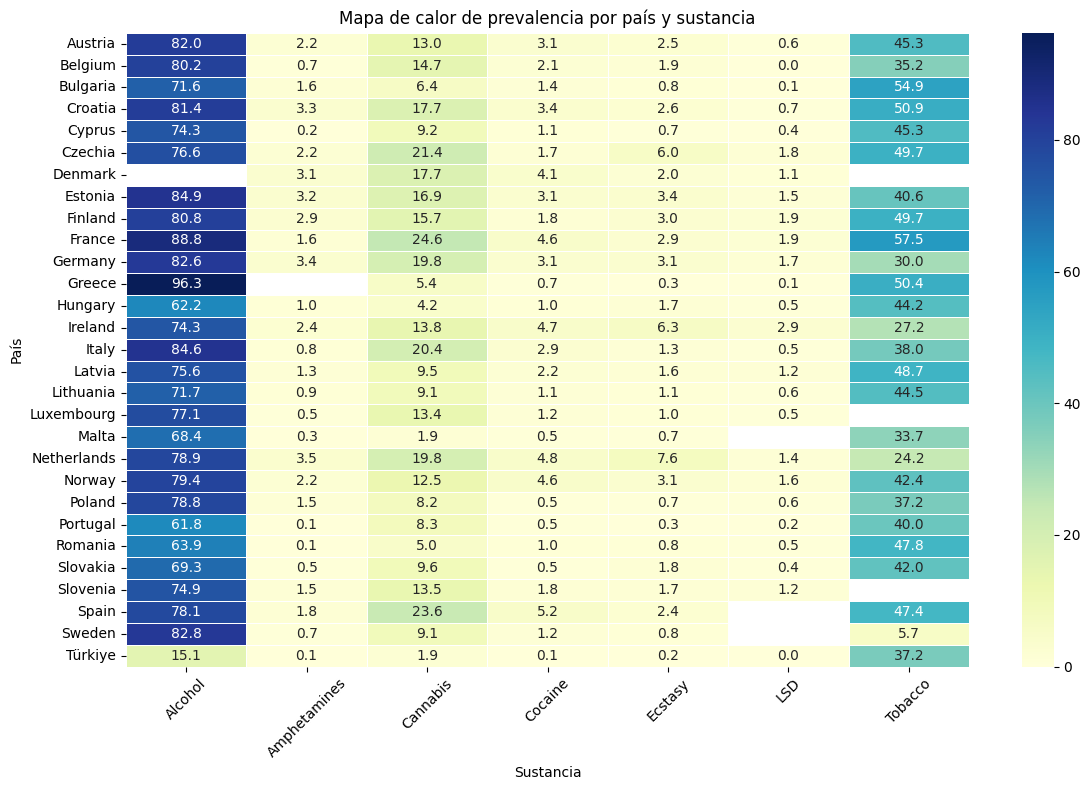

In [365]:
plt.figure(figsize=(12,8))
sns.heatmap(
    pivot,
    annot=True,        
    fmt=".1f",        
    cmap="YlGnBu",    
    linewidths=0.5 
)
plt.title("Mapa de calor de prevalencia por país y sustancia")
plt.ylabel("País")
plt.xlabel("Sustancia")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Al observar la tabla y el gráfico, se destaca que la prevalencia de consumo varía de forma notable entre países y sustancias, y, además, esta variación también está marcada por el género. Por ejemplo, en Austria, tanto hombres como mujeres presentan un consumo relativamente elevado de alcohol, con valores promedio de alrededor de 82% para hombres y 81% para mujeres. Esto indicaría que en este estado el alcohol es una sustancia ampliamente consumida y que la diferencia entre géneros es mínima, hecho que podría reflejar una normalización social del consumo de alcohol para ambos sexos.

En contraste, al analizar sustancias como el Cannabis, los hombres tienden a tener prevalencias más altas que las mujeres en casi todos los estados. En Austria, la prevalencia masculina es de 13.4% frente a 12.4% en mujeres, mientras que en Croacia la diferencia es más marcada, con 22.7% en hombres y 12.5% en mujeres. Esto indicaría que para ciertas drogas ilegales o recreativas existe una brecha de género destacable, probablemente influenciada por factores culturales, sociales y psicológicos que hacen que los hombres tengan mayor o disposición al consumo.

Por su parte, sustancias como el extasis o el LSD tienen prevalencias muy bajas para ambos géneros en la mayoría de los países. No obstante, cuando se consumen, los hombres superan sistemáticamente a las mujeres. Por ejemplo, en Bélgica, el consumo masculino de Cannabis es casi el doble que el femenino (19.3% vs 0.8%). Esto sugiere que, aunque el consumo sea poco frecuente, el patrón de género se mantiene constante.

Asimismo, el tabaco y el alcohol son sustancias con prevalencias altas y relativamente homogéneas entre países, a pesar de que hay diferencias masculinas algo más notorias en la mayoría de los casos. Por ejemplo, en Malta, la prevalencia masculina de alcohol es muy alta (aproximadamente 73%), mientras que la femenina también es elevada pero menor (aproximadamente 55%). 


En términos generales, este análisis multivariante ha permitido identificar varias conclusiones: 

* Los hombres tienden a consumir más que las mujeres en casi todas las sustancias excepto alcohol en algunos países
* Las diferencias de género son más acentuadas en drogas ilegales que en las legales
* La prevalencia de consumo varía entre países, reflejando factores culturales Y sociales que influyen en los hábitos de consumo

*Países y brecha de género*

In [366]:
topN = 10
rank_gap = (
    df_drugs.dropna(subset=["gender_gap"])
    .sort_values("gender_gap", ascending=False)
    .groupby("substance")
    .head(topN)
)

rank_gap[["substance", "country", "survey_year", "gender_gap"]]

,substance,country,survey_year,gender_gap
468,Alcohol,Hungary,2019,38.4
469,Alcohol,Hungary,2019,35.9
592,Alcohol,Latvia,2015,32.2
182,Tobacco,Cyprus,2019,30.5
633,Tobacco,Lithuania,2021,29.7
...,...,...,...,...
318,LSD,Finland,2018,3.2
624,LSD,Lithuania,2021,3.1
461,LSD,Hungary,2019,3.0
321,LSD,Finland,2018,2.8


El análisis de los países con mayor brecha de género facilita información realtiva a las diferencias en el consumo de drogas entre hombres y mujeres en Europa. Al observar el alcohol, se evidencia que Hungría y Letonia presentan las brechas más pronunciadas, con diferencias superiores al 30 %. Esto indica que, en estos países, los hombres consumen alcohol de manera considerablemente mayor que las mujeres, hecho que podría reflejar normas culturales más permisivas hacia el consumo masculino o mayores oportunidades de exposición social al alcohol. Para el tabaco, los países con mayores brechas son Chipre y Lituania, con diferencias cercanas al 30 %, mostrando patrones similares de desigualdad de género en sustancias legales.

En contraste, para drogas ilegales como el LSD, las brechas de género son mucho menores, generalmente alrededor del 3%, lo que indica que el consumo se distribuye de manera más equilibrada entre hombres y mujeres. Este patrón puede deberse a que estas sustancias son menos comunes, con acceso limitado, o a que los factores sociales que promueven diferencias de género tienen menos influencia en su uso. 

En general, estos resultados sugieren que la magnitud de la brecha de género depende tanto del tipo de sustancia como del contexto cultural y social de cada país: Las drogas legales, que son más accesibles y socialmente normalizadas, muestran desigualdades más marcadas, mientras que para las drogas ilegales, el consumo se acerca a una distribución más equitativa.

**Contraste de hipótesis: prevalencia, sustancia y país**

Debido a que no todos los países tienen datos completos de todas las sustancias al mismo tiempo, no ha sido posible realizar un MANOVA global. Por ello, se realizaron ANOVA univariantes por sustancia que permitirá realizar el contraste de hipótesis al evaluar si existen diferencias significativas entre países en la prevalencia del consumo, lo que permite contrastar la hipótesis H2 de manera parcial pero válida.

In [7]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

df_clean = df_drugs[
    (df_drugs["recall_period"] == "Last year") &
    (df_drugs["prevalence_(%)"].notna())
].copy()

anova_results = {}

for substance in df_clean["substance"].unique():
    df_sub = df_clean[df_clean["substance"] == substance]

    # Necesitamos al menos 2 observaciones por país
    counts = df_sub["country"].value_counts()
    valid_countries = counts[counts > 1].index
    df_sub = df_sub[df_sub["country"].isin(valid_countries)]

    if df_sub["country"].nunique() < 2:
        continue

    model = ols(
        'Q("prevalence_(%)") ~ C(country)',
        data=df_sub
    ).fit()

    anova_table = sm.stats.anova_lm(model, typ=2)
    anova_results[substance] = anova_table

    print(f"\nANOVA para {substance}")
    print(anova_table)


ANOVA para Cannabis
                 sum_sq    df         F    PR(>F)
C(country)  1052.933393  27.0  1.839119  0.057499
Residual     593.725000  28.0       NaN       NaN

ANOVA para Cocaine
               sum_sq    df         F    PR(>F)
C(country)  54.583571  27.0  3.081393  0.002094
Residual    18.370000  28.0       NaN       NaN

ANOVA para Amphetamines
             sum_sq    df         F    PR(>F)
C(country)  27.7725  25.0  3.503141  0.001127
Residual     8.2450  26.0       NaN       NaN

ANOVA para Ecstasy
               sum_sq    df         F    PR(>F)
C(country)  92.343393  27.0  3.475359  0.000805
Residual    27.555000  28.0       NaN       NaN

ANOVA para LSD
               sum_sq    df         F    PR(>F)
C(country)  12.325577  25.0  3.130305  0.002608
Residual     4.095000  26.0       NaN       NaN

ANOVA para Alcohol
                  sum_sq    df          F        PR(>F)
C(country)  11321.054815  26.0  56.571855  1.654218e-17
Residual      207.815000  27.0        NaN     

Los resultados muestran que, en el caso del Cannabis, el valor de p fue 0,057, superior al umbral de significancia de 0,05. Esto indica que, aunque hay variaciones entre estados, no se detectan diferencias significativas en su consumo (algunas diferencias menores entre países no son suficientemente grandes como para ser significativas estadísticamente)

Por otro lado, para sustancias como Cocaína, Anfetaminas, Éxtasis y LSD, los valores de p fueron todos inferiores a 0,05, lo que señala que sí existen diferencias significativas entre países. Así, el consumo de estas drogas no es homogéneo en Europa: algunos países tienen niveles de consumo claramente más altos que otros, mostrando patrones de uso específicos por país.

En el caso de las sustancias legales, como Alcohol y Tabaco, los resultados son aún más contundentes, con valores de p extremadamente bajos (p << 0,001) y valores F muy altos. Esto indicaría que las diferencias entre países en el consumo de alcohol y tabaco son muy claras, y que la variabilidad observada entre países es mucho mayor que la variabilidad dentro de cada país.

En conjunto, estos resultados permiten concluir que, a excepción del Cannabis, la prevalencia del consumo de estupefacientes varía significativamente entre países europeos. Por lo tanto, los datos proporcionan apoyo parcial a la hipótesis H2, demostrando que los patrones de consumo no son uniformes y que existen diferencias nacionales claras para la mayoría de las sustancias analizadas.

**Conclusión**

El análisis multivariante se ha focalizado en estudiar simultáneamente varias dimensiones del consumo de estupefaciente en Europa, explorando cómo la prevalencia se distribuye por país, por sustancia y por sexo. Para ello, se han construido tablas pivot y gráficas que nos permiten visualizar patrones complejos y comparaciones múltiples de manera intuitiva.

El primer enfoque consistió en analizar la prevalencia media de consumo por país y sustancia mediante un mapa de calor. Este gráfico mostró claramente que existen diferencias significativas entre países: algunos países presentan tasas elevadas de consumo de ciertas drogas, mientras que otros registran niveles relativamente bajos, lo que sugiere que la distribución del consumo no es homogénea a nivel europeo y que los factores nacionales probablemente influyen en los patrones de uso.

Asimismo, se ha incorporado la dimensión de género, creando un pivot que separaba la prevalencia por hombres y mujeres. Los resultados muestran que, en general, los hombres tienden a consumir más que las mujeres, especialmente para sustancias como el alcohol, el cannabis y el tabaco, aunque la magnitud de la brecha varía considerablemente entre países. Por ejemplo, países como Hungría y Latvia presentan diferencias especialmente altas en alcohol, mientras que para LSD o ciertas drogas menos consumidas la brecha es mínima. 

Posteriormente, se han identificado los estados con mayor brecha de género por sustancia, observándose que Hungría lidera la diferencia para alcohol, mientras que Chipre y Lituania destacan en tabaco. Estas observaciones podrían ayudar a priorizar políticas de prevención o campañas específicas según sustancia y país.

En conjunto, el análisis multivariante nos ha permitido visualizar patrones complejos que no se perciben en análisis univariantes o bivariantes, pudiendo identificar diferencias por país, género y sustancia, así como la interacción entre estas variables.

## 2.4 CONCLUSIÓN HIPÓTESIS 2

En la hipótesis 2 *Existen diferencias en la prevalencia del consumo de estupefacientes entre países europeos* se ha planteado la existencia de diferencias respecto la prevalencia del consumo de drogas entre países europeos. Para analizarla, se ha realizado un análisis a tres niveles: univariante, bivariante y multivariante.

El **análisis univariante** ha mostrado una distribución desigual de registros entre países y sustancias. Por ejemplo, Austria, Bulgaria o Croacia cuentan con 42 observaciones, mientras que Malta o Bélgica tienen muchas menos, lo que indica una heterogeneidad en la disponibilidad de datos por país. Esta información descriptiva es importante para contextualizar la interpretación posterior.

En el **análisis bivariante**, al estudiar las relaciones categórica-categórica mediante tablas de contingencia, se apreciado que aunque la distribución de consumo varía entre países para cada sustancia, la prueba de chi-cuadrado no ha mostrado evidencia de dependencia significativa generalizada, lo que sugiere que algunas diferencias son visibles pero no significativas. Al analizar variables categóricas con variables numéricas, como el porcentaje de mujeres consumidoras o la prevalencia general por país, los análisis ANOVA han mostrado que sí existen variaciones entre países, pero con significancia estadística variable según el enfoque. 

Paralelamente, algunos países tienen patrones de consumo más altos para sustancias específicas, y el análisis relativo a la brecha de género ha evidenciado que en algunas sustancias, como alcohol y tabaco, los hombres consumen significativamente más que las mujeres en países como Hungría, Letonia o Lituania. Sin embargo, esta diferencia de género no se traduce en una diferencia generalizable en la prevalencia total de consumo entre países.

En conclusion, los resultados indican que no existen diferencias globales significativas en la prevalencia de consumo para todas las sustancias analizadas. No obstante, sí se observan diferencias significativas entre países para varias sustancias concretas, como Cocaína, Anfetaminas, Éxtasis, LSD, Alcohol y Tabaco (todas menos cannabis). Por ende, sí se acepta parcialmente la Hipótesis 2: existen diferencias significativas en la prevalencia del consumo de cocaina, tabaco, alcohol, anfetaminas y LSD entre países europeos, pero no de cannabis.

# CONCLUSIONES

En el presente EDA se ha analizado el consumo de diversas sustancias teniendo en cuenta variables como sustancia, país, edad y género, con el objetivo de analizar patrones de consumo y diferencias significativas entre grupos. 

A nivel univariante, se apreció que las sustancias más consumidas fueron Alcohol y tabaco, mientras que otras drogas como LSD o Cocaína mostraron prevalencias más bajas. Al considerar el género, se detectó que los hombres tienen un consumo más alto que las mujeres, reflejando una brecha de género notable. Por su parte, las diferencias por edad fueron menos evidentes, aunque en ciertos casos los jóvenes adultos mostraron un consumo ligeramente mayor en algunas sustancias como Cannabis y Cocaína.

El análisis bivariante permitió profundizar en estas relaciones. La comparación entre sustancia y país mostró variabilidad en la prevalencia de consumo, aunque los análisis de ANOVA indicaron que en general las diferencias por país sí fueron significativas para todas las sustancias menos para cannabis. Además, al considerar la sustancia combinada con el género, se apreciaronn diferencias significativas, destacando que los hombres consumen más que las mujeres en prácticamente todas las drogas y que la brecha de género es especialmente marcada en Alcohol y tabaco. La interacción entre edad y sustancia mostró efectos limitados, evidenciando que las diferencias por edad dependen del tipo de droga.

El análisis multivariante consolidó estas observaciones. Los resultados de MANOVA demostraron que la sustancia tiene un efecto altamente significativo sobre el consumo conjunto de hombres y mujeres, mientras que la edad no mostró un efecto global significativo. Las interacciones entre edad y sustancia presentaron relevancia solo en casos específicos. Asimismo, los mapas de calor y los análisis de brecha de género destacaron que algunas sustancias, sobre todo Alcohol y Tabaco, concentran las mayores diferencias entre hombres y mujeres, y que esta brecha se mantiene consistente a nivel de país.

En conjunto, el EDA permite concluir que el consumo de sustancias está fuertemente determinado por el tipo de droga y por el género del individuo, mientras que la edad y el país influyen de forma más limitada y dependiente de la sustancia específica. Las hipótesis planteadas se aceptan parcialmente: se confirma que existen diferencias significativas por sustancia y género, mientras que las diferencias por edad y país no son globalmente significativas. Esto indica que, para entender los patrones de consumo, el análisis debe centrarse en la sustancia y el género, considerando la edad y el país como factores moduladores más que determinantes.